In [148]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore",category=UserWarning)

In [149]:
class TransactionHistory:
    """
    Class that will separate transaction history by categories
    """
    def __init__(self):
        self.pool_address = None

        # basic dataframes references
        self.user_in_swap_df = None
        self.user_out_swap_df = None
        self.pool_investments_df = None
        self.pool_extractions_df = None
        self.anomalies_df = None

        # additional dataframes references with moving averages
        self.smaller_avg_in_swap_df = None
        self.bigger_avg_in_swap_df = None
        self.smaller_avg_out_swap_df = None
        self.bigger_avg_out_swap_df = None
        self.smaller_avg_investments_df = None
        self.bigger_avg_investmets_df = None
        self.smaller_avg_exractions_df = None
        self.bigger_avg_extractions_df = None
        self.smaller_avg_anomalies = None
        self.bigger_avg_anomalies = None


    def __contract_address_count__(self, s):
        return (s == self.pool_address).sum()

    def __set_mov_smaller_avg__(self, df: pd.DataFrame, smaller_avg: str) -> pd.DataFrame:
        """
        generate dataframe with smaller cycle of moving average

        Keyword arguments:
        df (pandas.DataFrame) -- table for which moving average should be found
        smaller_avg (str) -- string that defines cycle size to calculate
            moving average
        """
        df_time = df.copy()
        df_time.UnixTimestamp = pd.to_datetime(df_time.UnixTimestamp, unit='s')
        df_time.index = df_time.UnixTimestamp
        return df_time.resample(smaller_avg).mean()

    
    def __set_mov_bigger_avg__(self, df: pd.DataFrame, bigger_avg: str) -> pd.DataFrame:
        """
        generate dataframe with bigger cycle of moving average (resampling)

        Keyword arguments:
        df (pandas.DataFrame) -- table for which moving average should be found
        smaller_avg (str) -- string that defines cycle size to calculate
            moving average
        """
        df_time = df.copy()
        df_time.UnixTimestamp = pd.to_datetime(df_time.UnixTimestamp, unit='s')
        df_time.index = df_time.UnixTimestamp
        return df_time.rolling(bigger_avg).mean()
    
    def classify_history(self, transactions_df: pd.DataFrame):
        """
        Separate history in different dataframes conform transaction parameters
        ('swapping in/out', 'investments, extractions' and 'anomalies') that
        can be requested as current class object fields
        
        Keyword arguments:
        transactions_df (pandas.DataFrame) -- table of all transactions
        """
        # find address of the pool - most of the transactions will be related to pool
        self.pool_address = transactions_df['From'].mode()[0]
        
        # create matrix of transactions hashes and counters of in/out pool movements
        group_df = transactions_df.groupby('Txhash').agg({
            'From': self.__contract_address_count__,
            'To': self.__contract_address_count__
        })
        
        # form lists of swapping transactions, investments, extractions, anomalies
        swap_txhash_list = group_df[(group_df['From'] == 1) & (group_df['To'] == 1)].index.values
        investments_list = group_df[group_df['To'] == 2].index.values
        extractions_list = group_df[group_df['From'] == 2].index.values
        anomalies_list = group_df[(group_df['From'] > 2) | (group_df['To'] > 2)].index.values

        # record swapping in/out operations
        self.user_in_swap_df = transactions_df[(transactions_df['Txhash'].isin(swap_txhash_list)) & 
                                                (transactions_df['To'] == self.pool_address)]
        self.user_out_swap_df = transactions_df[(transactions_df['Txhash'].isin(swap_txhash_list)) & 
                                                (transactions_df['From'] == self.pool_address)]

        # record investments and extractions
        self.pool_investments_df = transactions_df[transactions_df['Txhash'].isin(investments_list)]
        self.pool_extractions_df = transactions_df[transactions_df['Txhash'].isin(extractions_list)]
        
        # record anomalies
        self.anomalies_df = transactions_df[transactions_df['Txhash'].isin(anomalies_list)]


    def form_moving_averages_for_token(self, smaller_average: str, bigger_average: str, target_token: str):
        """
        calculate tables with moving averages for given token and append those tables to object fields

        Keyword argument:
        smaller_average (str) -- string formatted smaller cycle to find moving average
        bigger_average (str) -- string formatted bigger cycle to find moving average
        target_token (str) -- token name for which moving average should be calculated
        """
        self.smaller_avg_in_swap_df = self.__set_mov_smaller_avg__(
            self.user_in_swap_df[self.user_in_swap_df['TokenSymbol'] == target_token], smaller_average)
        self.bigger_avg_in_swap_df = self.__set_mov_bigger_avg__(
            self.user_in_swap_df[self.user_in_swap_df['TokenSymbol'] == target_token], bigger_average)
        
        self.smaller_avg_out_swap_df = self.__set_mov_smaller_avg__(
            self.user_out_swap_df[self.user_out_swap_df['TokenSymbol'] == target_token], smaller_average)
        self.bigger_avg_out_swap_df = self.__set_mov_bigger_avg__(
            self.user_out_swap_df[self.user_out_swap_df['TokenSymbol'] == target_token], bigger_average)
        
        self.smaller_avg_investments_df = self.__set_mov_smaller_avg__(
            self.pool_investments_df[self.pool_investments_df['TokenSymbol'] == target_token], smaller_average)
        self.bigger_avg_investmets_df = self.__set_mov_bigger_avg__(
            self.pool_investments_df[self.pool_investments_df['TokenSymbol'] == target_token], bigger_average)
        
        self.smaller_avg_exractions_df = self.__set_mov_smaller_avg__(
            self.pool_extractions_df[self.pool_extractions_df['TokenSymbol'] == target_token], smaller_average)
        self.bigger_avg_extractions_df = self.__set_mov_bigger_avg__(
            self.pool_extractions_df[self.pool_extractions_df['TokenSymbol'] == target_token], bigger_average)
        
        self.smaller_avg_anomalies = self.__set_mov_smaller_avg__(
            self.anomalies_df[self.anomalies_df['TokenSymbol'] == target_token], smaller_average)
        self.bigger_avg_anomalies = self.__set_mov_bigger_avg__(
            self.anomalies_df[self.anomalies_df['TokenSymbol'] == target_token], bigger_average)


    def lineplots_matrix(self, x_size: int, y_size: int, hspace:int, wspace: int, period_name: str):
        """
        make lineplots matrix

        Keyword arguments:
        x_size (int) -- matrix width
        y_size (int) -- matrix height
        hspace (int) -- inter-elements height
        wspace (int) -- inter-elements width
        period_name (str) -- name of analyzed time period
        """
        # get tokens present in dataframe
        tokens = self.user_in_swap_df['TokenSymbol'].unique()
        print(tokens)
        plt.figure(figsize=(x_size, y_size))

        # first currency graphs
        plt.subplot(5, 2, 1)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.user_in_swap_df[self.user_in_swap_df['TokenSymbol'] == tokens[0]], 
                    x='Datetime', y='Value', color='red').set_title(tokens[0] + ' swapping in (' + period_name + ')')
        plt.subplot(5, 2, 2)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.user_out_swap_df[self.user_out_swap_df['TokenSymbol'] == tokens[0]], 
                    x='Datetime', y='Value', color='green').set_title(tokens[0] + ' swapping out (' + period_name + ')')

        # second currency graphs
        plt.subplot(5, 2, 3)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.user_in_swap_df[self.user_in_swap_df['TokenSymbol'] == tokens[1]], 
                    x='Datetime', y='Value', color='red').set_title(tokens[1] + ' swapping in (' + period_name + ')')
        plt.subplot(5, 2, 4)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.user_out_swap_df[self.user_out_swap_df['TokenSymbol'] == tokens[1]], 
                    x='Datetime', y='Value', color='green').set_title(tokens[1] + ' swapping out (' + period_name + ')')


        plt.subplot(5, 2, 5)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.pool_investments_df[self.pool_investments_df['TokenSymbol'] == tokens[0]],
                    x='Datetime', y='Value', color='orange').set_title(tokens[0] + ' investments (' + period_name + ')')
        plt.subplot(5, 2, 6)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.pool_investments_df[self.pool_investments_df['TokenSymbol'] == tokens[1]],
                    x='Datetime', y='Value', color='magenta').set_title(tokens[1] + ' investments (' + period_name + ')')

        # extractions
        plt.subplot(5, 2, 7)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.pool_extractions_df[self.pool_extractions_df['TokenSymbol'] == tokens[0]],
                    x='Datetime', y='Value', color='orange').set_title(tokens[0] + ' extractions (' + period_name + ')')
        plt.subplot(5, 2, 8)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.pool_extractions_df[self.pool_extractions_df['TokenSymbol'] == tokens[1]],
                    x='Datetime', y='Value', color='magenta').set_title(tokens[1] + ' extractions (' + period_name + ')')

        # anomalies
        plt.subplot(5, 2, 9)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.anomalies_df[self.anomalies_df['TokenSymbol'] == tokens[0]],
                    x='Datetime', y='Value', color='orange').set_title(tokens[0] + ' anomalies (' + period_name + ')')
        plt.subplot(5, 2, 10)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.anomalies_df[self.anomalies_df['TokenSymbol'] == tokens[1]],
                    x='Datetime', y='Value', color='magenta').set_title(tokens[1] + ' anomalies (' + period_name + ')')

        plt.subplots_adjust(hspace=hspace, wspace=wspace)
        plt.show()


    def histplots_matrix(self, x_size: int, y_size: int, hspace:int, wspace: int, period_name: str, bins_v: int):
        """
        make histplots matrix

        Keyword arguments:
        x_size (int) -- matrix width
        y_size (int) -- matrix height
        hspace (int) -- inter-elements height
        wspace (int) -- inter-elements width
        period_name (str) -- name of analyzed time period
        """
        # get tokens present in dataframe
        tokens = self.user_in_swap_df['TokenSymbol'].unique()
        print(tokens)
        plt.figure(figsize=(x_size, y_size))

        # first currency graphs
        plt.subplot(5, 2, 1)
        plt.xticks(rotation=45)
        sns.histplot(data=self.user_in_swap_df[self.user_in_swap_df['TokenSymbol'] == tokens[0]], 
                    x='Value', color='red', bins=bins_v).set_title(tokens[0] + ' swapping in (' + period_name + ')')
        plt.subplot(5, 2, 2)
        plt.xticks(rotation=45)
        sns.histplot(data=self.user_out_swap_df[self.user_out_swap_df['TokenSymbol'] == tokens[0]], 
                    x='Value', color='green', bins=bins_v).set_title(tokens[0] + ' swapping out (' + period_name + ')')

        # second currency graphs
        plt.subplot(5, 2, 3)
        plt.xticks(rotation=45)
        sns.histplot(data=self.user_in_swap_df[self.user_in_swap_df['TokenSymbol'] == tokens[1]], 
                    x='Value', color='red', bins=bins_v).set_title(tokens[1] + ' swapping in (' + period_name + ')')
        plt.subplot(5, 2, 4)
        plt.xticks(rotation=45)
        sns.histplot(data=self.user_out_swap_df[self.user_out_swap_df['TokenSymbol'] == tokens[1]], 
                    x='Value', color='green', bins=bins_v).set_title(tokens[1] + ' swapping out (' + period_name + ')')


        plt.subplot(5, 2, 5)
        plt.xticks(rotation=45)
        sns.histplot(data=self.pool_investments_df[self.pool_investments_df['TokenSymbol'] == tokens[0]],
                    x='Value', color='orange', bins=bins_v).set_title(tokens[0] + ' investments (' + period_name + ')')
        plt.subplot(5, 2, 6)
        plt.xticks(rotation=45)
        sns.histplot(data=self.pool_investments_df[self.pool_investments_df['TokenSymbol'] == tokens[1]],
                    x='Value', color='magenta', bins=bins_v).set_title(tokens[1] + ' investments (' + period_name + ')')

        # extractions
        plt.subplot(5, 2, 7)
        plt.xticks(rotation=45)
        sns.histplot(data=self.pool_extractions_df[self.pool_extractions_df['TokenSymbol'] == tokens[0]],
                    x='Value', color='orange', bins=bins_v).set_title(tokens[0] + ' extractions (' + period_name + ')')
        plt.subplot(5, 2, 8)
        plt.xticks(rotation=45)
        sns.histplot(data=self.pool_extractions_df[self.pool_extractions_df['TokenSymbol'] == tokens[1]],
                    x='Value', color='magenta', bins=bins_v).set_title(tokens[1] + ' extractions (' + period_name + ')')

        # anomalies
        plt.subplot(5, 2, 9)
        plt.xticks(rotation=45)
        sns.histplot(data=self.anomalies_df[self.anomalies_df['TokenSymbol'] == tokens[0]],
                    x='Value', color='orange', bins=bins_v).set_title(tokens[0] + ' anomalies (' + period_name + ')')
        plt.subplot(5, 2, 10)
        plt.xticks(rotation=45)
        sns.histplot(data=self.anomalies_df[self.anomalies_df['TokenSymbol'] == tokens[1]],
                    x='Value', color='magenta', bins=bins_v).set_title(tokens[1] + ' anomalies (' + period_name + ')')

        plt.subplots_adjust(hspace=hspace, wspace=wspace)
        plt.show()


    def lineplots_moving_averages_matrix_by_token(self, x_size: int, y_size: int, hspace: int, wspace: int,
                                first_token: str, second_token: str, 
                                period_name: str, smaller_avg: str, bigger_avg: str):
        """
        create lineplots matrix that shows moving averages for pool tokens

        Keyword arguments:
        x_size (int) -- width of lineplots matrix
        y_size (int) -- height of lineplots matrix
        hspace (int) -- height space between matrix subplots
        wspace (int) -- width space between matrix subplots
        first_token (str) -- name of left side token
        second_token (str) -- name of right side token
        period_name (str) -- string that defines time period of transactions
        smaller_avg (str) -- time cycle for finding small moving averages
        bigger_avg (str) -- time cycle for finding bigger moving averages
        """
        
        plt.figure(figsize=(x_size, y_size))

        # -----------------------------         first_token section     -----------------------------------
        self.form_moving_averages_for_token(smaller_avg, bigger_avg, first_token)

        plt.subplot(5, 2, 1)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_in_swap_df, x='UnixTimestamp', y='Value', color='red'
                    ).set_title(first_token + ' swap in moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 1)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_in_swap_df, x='UnixTimestamp', y='Value', color='green'
                    ).set_title(first_token + ' swap in moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')

        plt.subplot(5, 2, 3)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_out_swap_df, x='UnixTimestamp', y='Value', color='red'
                    ).set_title(first_token + ' swap out moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 3)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_out_swap_df, x='UnixTimestamp', y='Value', color='green'
                    ).set_title(first_token + ' swap out moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')

        plt.subplot(5, 2, 5)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_investments_df, x='UnixTimestamp', y='Value', color='red'
                    ).set_title(first_token + ' investments moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 5)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_investmets_df, x='UnixTimestamp', y='Value', color='green'
                    ).set_title(first_token + ' investments moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')

        plt.subplot(5, 2, 7)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_exractions_df, x='UnixTimestamp', y='Value', color='red'
                    ).set_title(first_token + ' extractions moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 7)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_extractions_df, x='UnixTimestamp', y='Value', color='green'
                    ).set_title(first_token + ' extractions moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')

        plt.subplot(5, 2, 9)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_anomalies, x='UnixTimestamp', y='Value', color='red'
                    ).set_title(first_token + ' anomalies moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 9)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_anomalies, x='UnixTimestamp', y='Value', color='green'
                    ).set_title(first_token + ' anomalies moving average (' + period_name + '), green - ' + 
                                bigger_avg + ' avg, red - ' + smaller_avg + ' avg')

        # -----------------------------         second_token section     -------------------------------------
        self.form_moving_averages_for_token(smaller_avg, bigger_avg, second_token)

        plt.subplot(5, 2, 2)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_in_swap_df, x='UnixTimestamp', y='Value', color='orange'
                    ).set_title(second_token + ' swap in moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 2)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_in_swap_df, x='UnixTimestamp', y='Value', color='magenta'
                    ).set_title(second_token + ' swap in moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')

        plt.subplot(5, 2, 4)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_out_swap_df, x='UnixTimestamp', y='Value', color='orange'
                    ).set_title(second_token + ' swap out moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 4)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_out_swap_df, x='UnixTimestamp', y='Value', color='magenta'
                    ).set_title(second_token + ' swap out moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')

        plt.subplot(5, 2, 6)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_investments_df, x='UnixTimestamp', y='Value', color='orange'
                    ).set_title(second_token + ' investments moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 6)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_investmets_df, x='UnixTimestamp', y='Value', color='magenta'
                    ).set_title(second_token + ' investments moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')

        plt.subplot(5, 2, 8)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_exractions_df, x='UnixTimestamp', y='Value', color='orange'
                    ).set_title(second_token + ' extractions moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 8)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_extractions_df, x='UnixTimestamp', y='Value', color='magenta'
                    ).set_title(second_token + ' extractions moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')

        plt.subplot(5, 2, 10)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.smaller_avg_anomalies, x='UnixTimestamp', y='Value', color='orange'
                    ).set_title(second_token + ' anomalies moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')
        plt.subplot(5, 2, 10)
        plt.xticks(rotation=45)
        sns.lineplot(data=self.bigger_avg_anomalies, x='UnixTimestamp', y='Value', color='magenta'
                    ).set_title(second_token + ' anomalies moving average (' + period_name + '), magenta - ' + 
                                bigger_avg + ' avg, orange - ' + smaller_avg + ' avg')

        plt.subplots_adjust(hspace=hspace, wspace=wspace)
        plt.show()

# High capitalization

## DAI/USDC

In [150]:
# read transaction history
dai_usdc_df = pd.read_csv(os.getcwd() + "\stress_test_sim\pools_history\high_DAI-USDC_01-10_31_10.csv", index_col=False)

# make sure that Value will be interpreted as floating point number, remove possible 0 value elements
dai_usdc_df.Value = dai_usdc_df.Value.str.replace(",", "")
dai_usdc_df.Value = dai_usdc_df.Value.astype("float")
dai_usdc_df = dai_usdc_df[dai_usdc_df.Value > 0]

# make sure that datetime parameter is interpreted as date
dai_usdc_df['Datetime'] = pd.to_datetime(dai_usdc_df['UnixTimestamp'], unit='s')

# form transaction history separated by categories
th = TransactionHistory()
th.classify_history(dai_usdc_df)

['USDC' 'DAI']


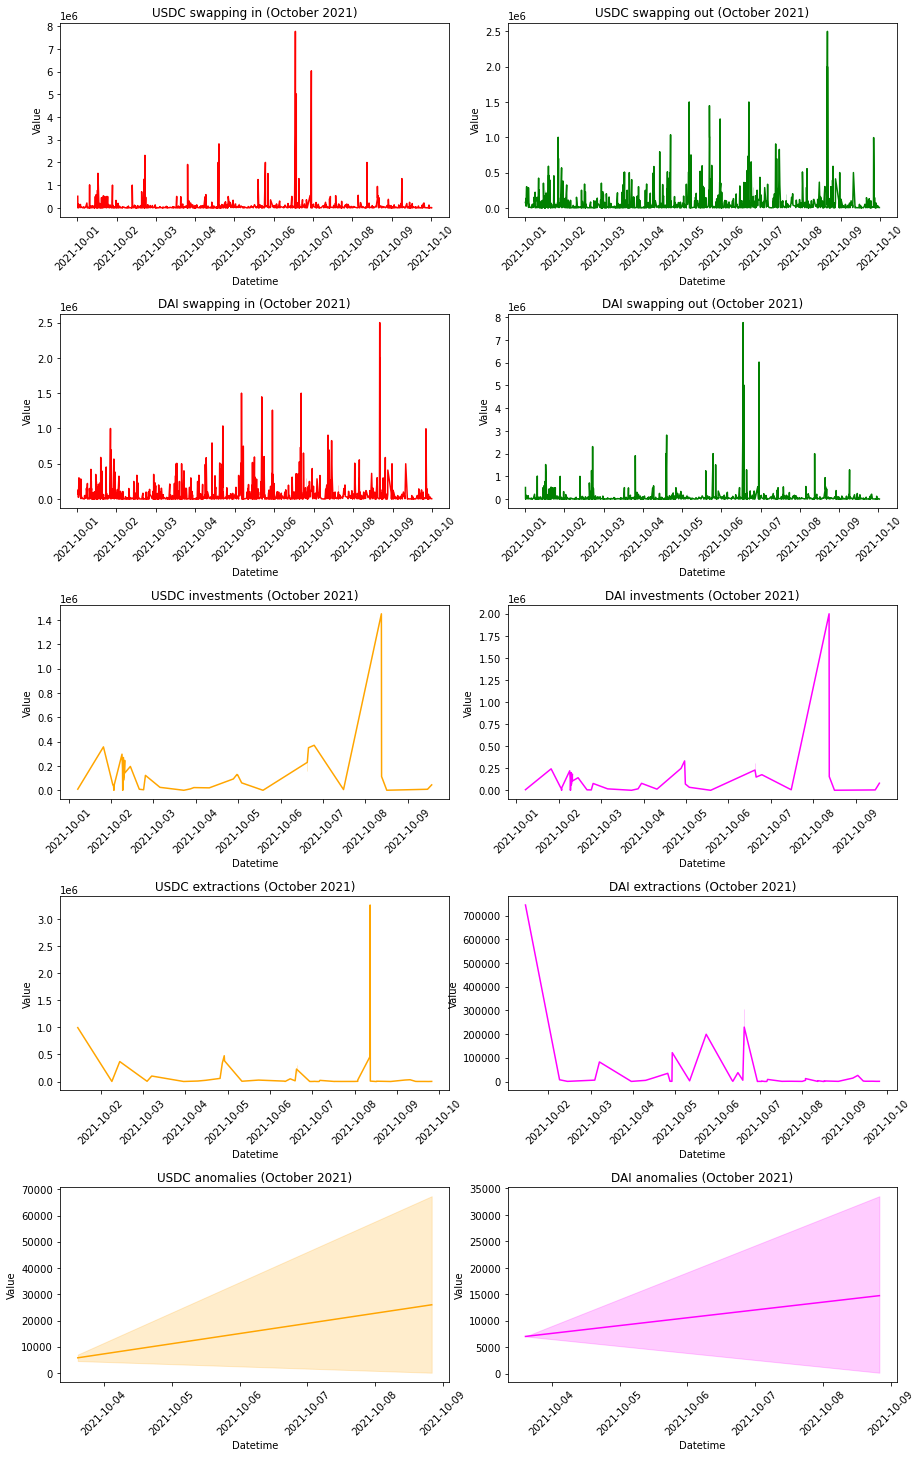

In [151]:
th.lineplots_matrix(15, 25, 0.5, 0.15, 'October 2021')

['USDC' 'DAI']


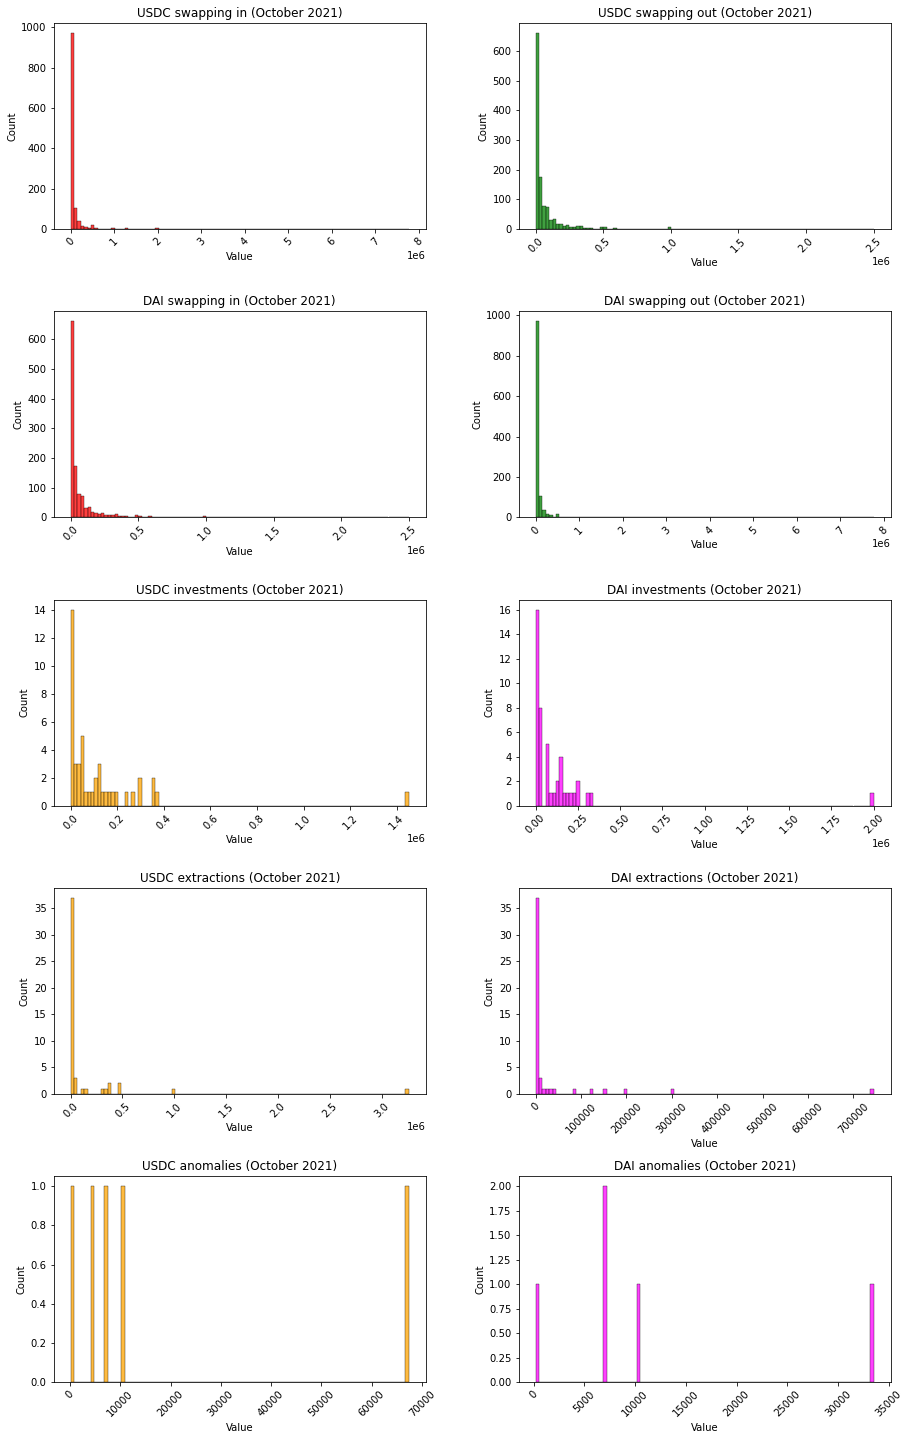

In [152]:
th.histplots_matrix(15, 25, 0.4, 0.25, 'October 2021', 100)

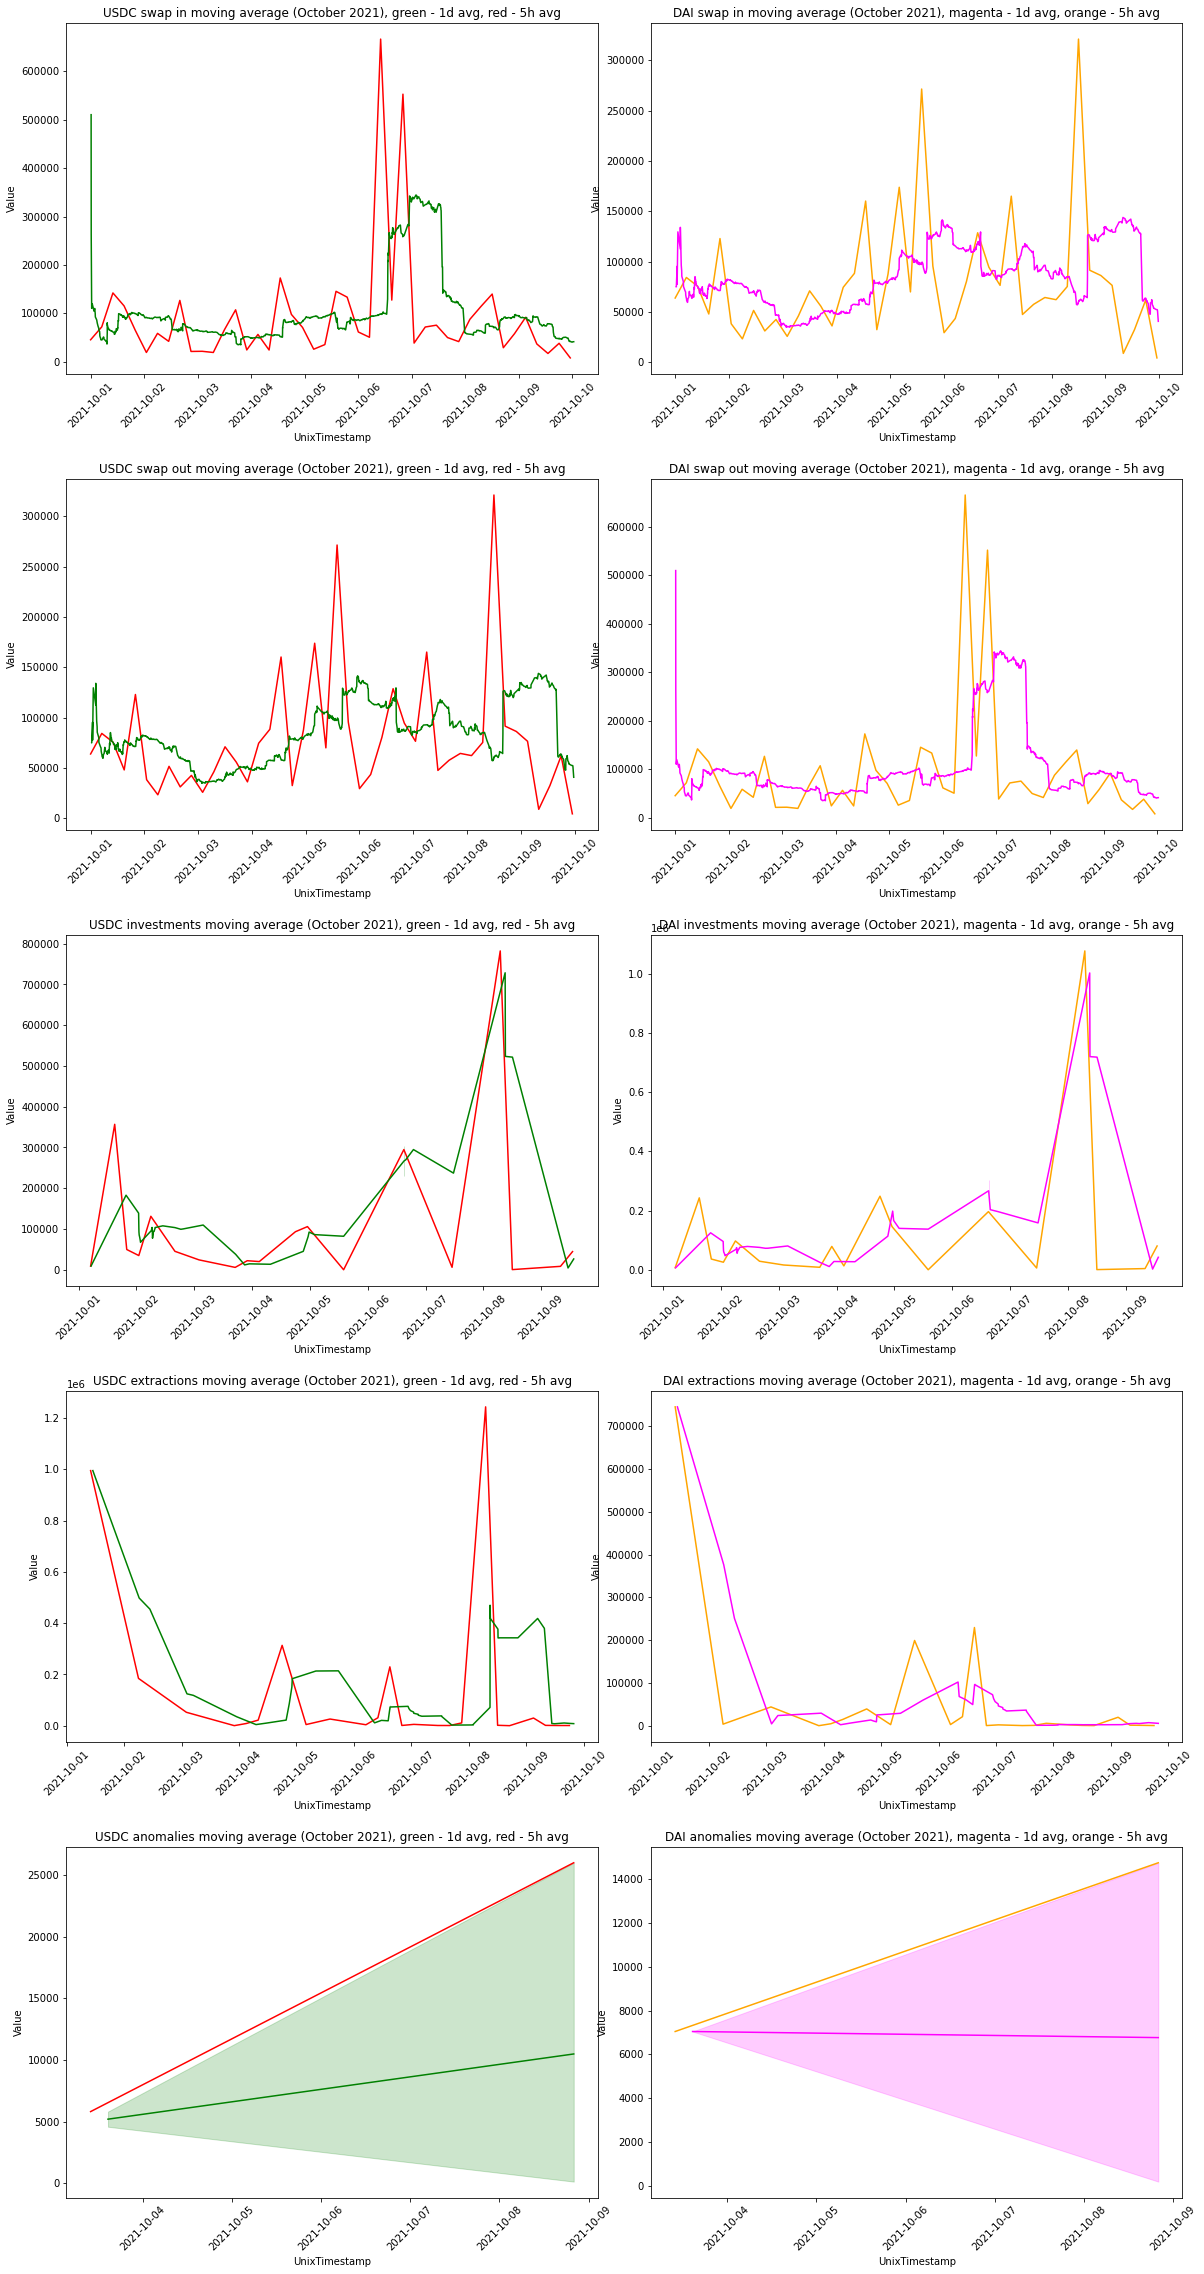

In [153]:
th.lineplots_moving_averages_matrix_by_token(20, 40, 0.3, 0.1, 'USDC', 'DAI', 'October 2021', '5h', '1d')

## ETH/USDC

In [154]:
# read transaction history
eth_usdc_df = pd.read_csv(os.getcwd() + "\stress_test_sim\pools_history\high_ETH-USDC_01-01_31-10.csv", index_col=False)

# make sure that Value will be interpreted as floating point number, remove possible 0 value elements
eth_usdc_df.Value = eth_usdc_df.Value.str.replace(",", "")
eth_usdc_df.Value = eth_usdc_df.Value.astype("float")
eth_usdc_df = eth_usdc_df[eth_usdc_df.Value > 0]

# make sure that datetime parameter is interpreted as date
eth_usdc_df['Datetime'] = pd.to_datetime(eth_usdc_df['UnixTimestamp'], unit='s')

# form transaction history separated by categories
th = TransactionHistory()
th.classify_history(eth_usdc_df)

['WETH' 'USDC']


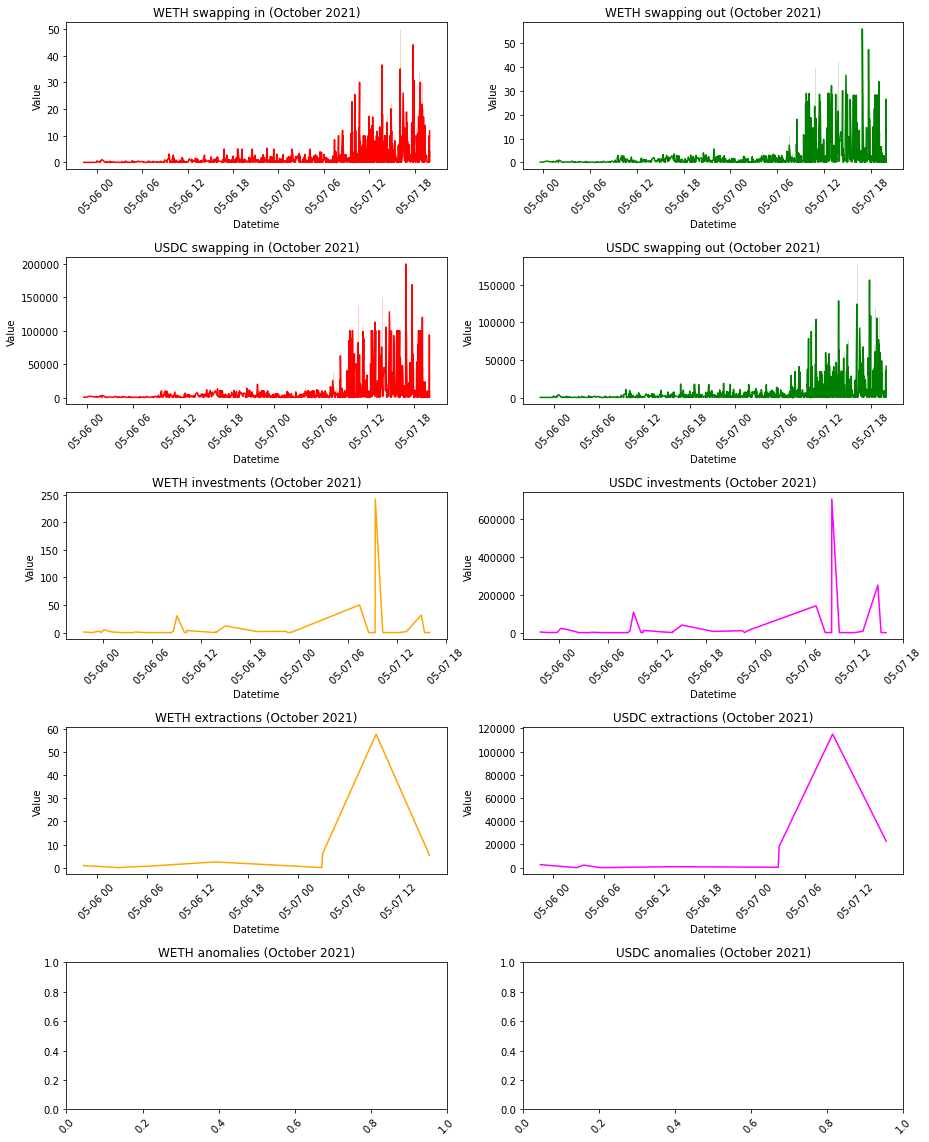

In [155]:
th.lineplots_matrix(15, 20, 0.6, 0.2, 'October 2021')

['WETH' 'USDC']


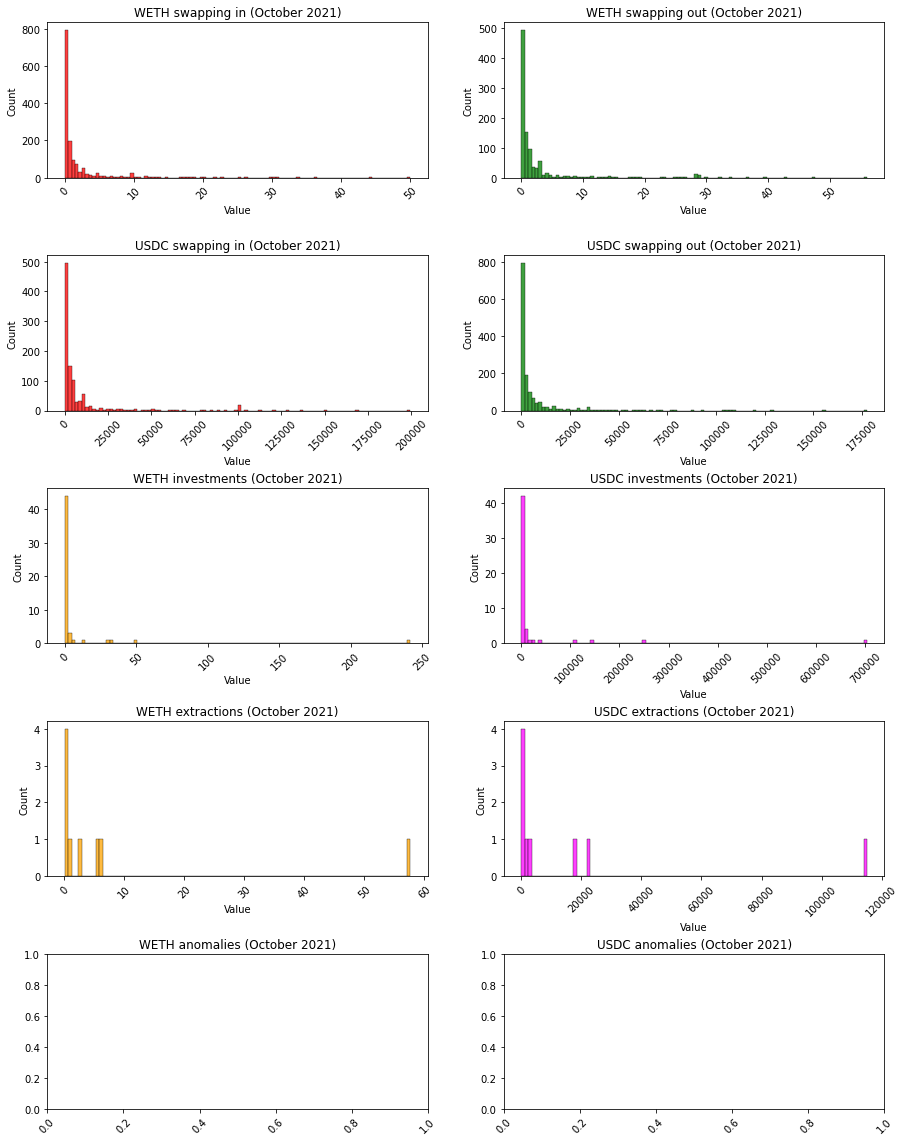

In [156]:
th.histplots_matrix(15, 20, 0.5, 0.2, 'October 2021', 100)

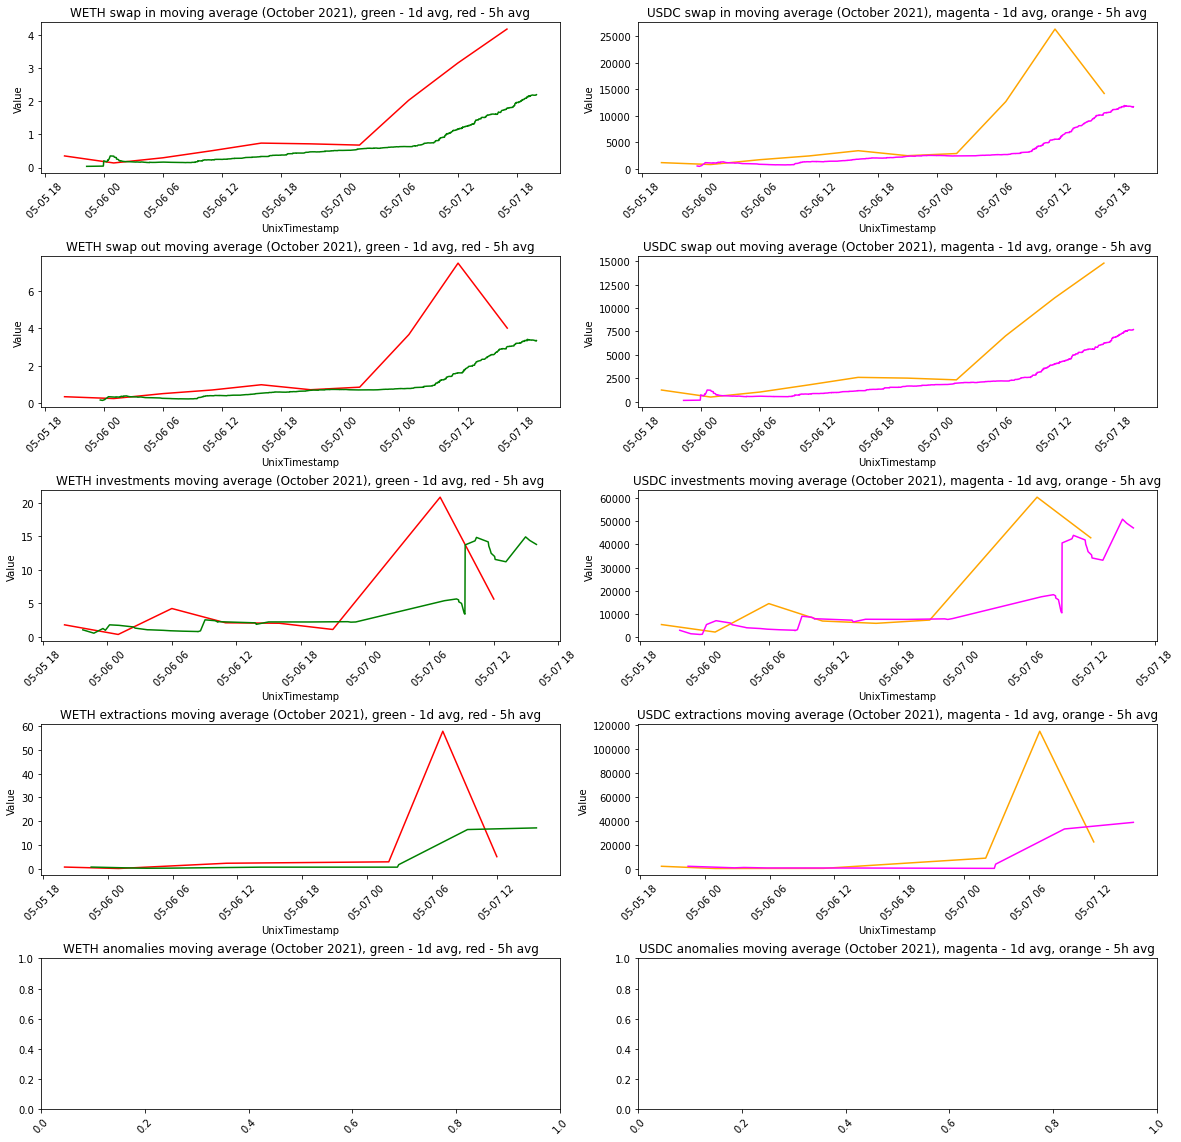

In [157]:
th.lineplots_moving_averages_matrix_by_token(20, 20, 0.55, 0.15, 'WETH', 'USDC', 'October 2021', '5h', '1d')

## ETH/USDT

In [158]:
# read transaction history
eth_usdt_df = pd.read_csv(os.getcwd() + "\stress_test_sim\pools_history\high_ETH-USDT_01-10_31-10.csv", index_col=False)

# make sure that Value will be interpreted as floating point number, remove possible 0 value elements
eth_usdt_df.Value = eth_usdt_df.Value.str.replace(",", "")
eth_usdt_df.Value = eth_usdt_df.Value.astype("float")
eth_usdt_df = eth_usdt_df[eth_usdt_df.Value > 0]

# make sure that datetime parameter is interpreted as date
eth_usdt_df['Datetime'] = pd.to_datetime(eth_usdt_df['UnixTimestamp'], unit='s')

# form transaction history separated by categories
th = TransactionHistory()
th.classify_history(eth_usdt_df)

['USDT' 'WETH']


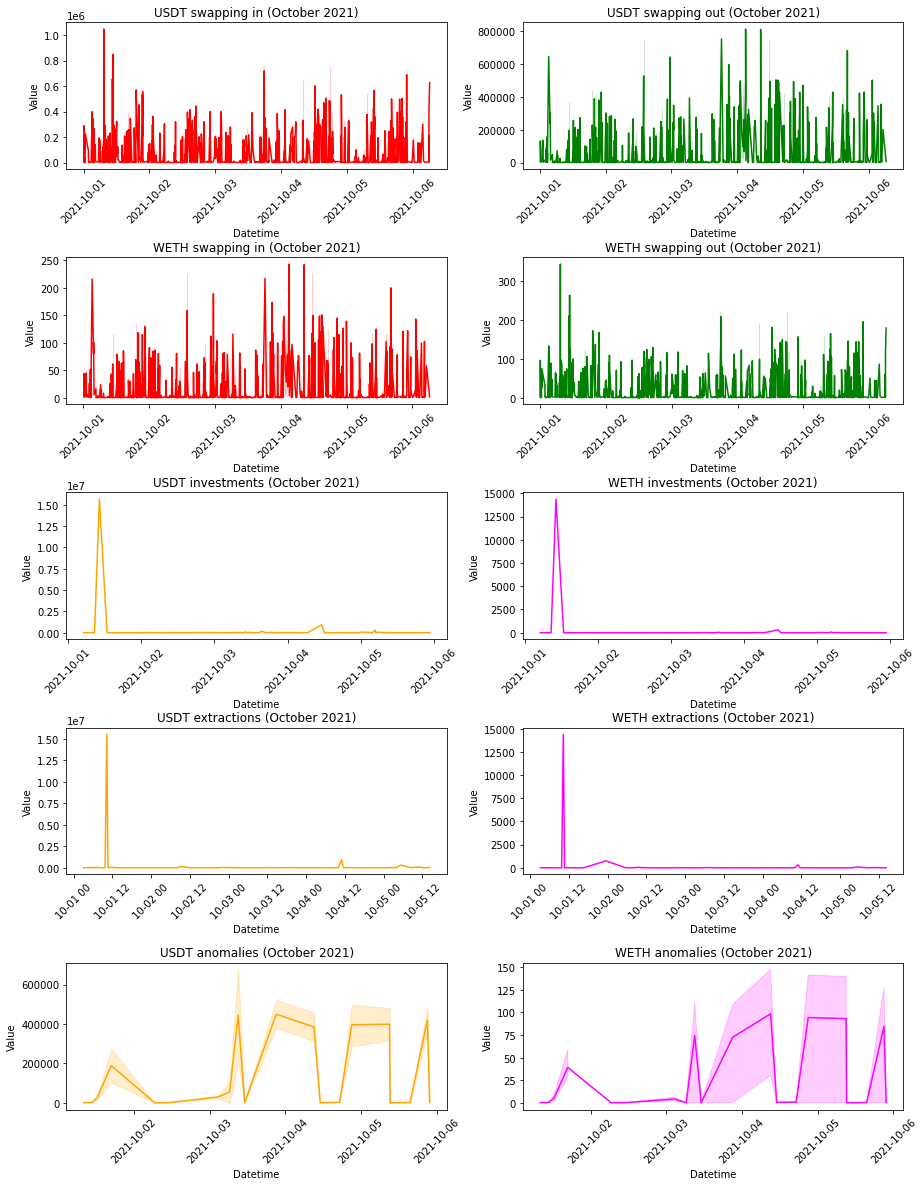

In [159]:
th.lineplots_matrix(15, 20, 0.6, 0.2, 'October 2021')

['USDT' 'WETH']


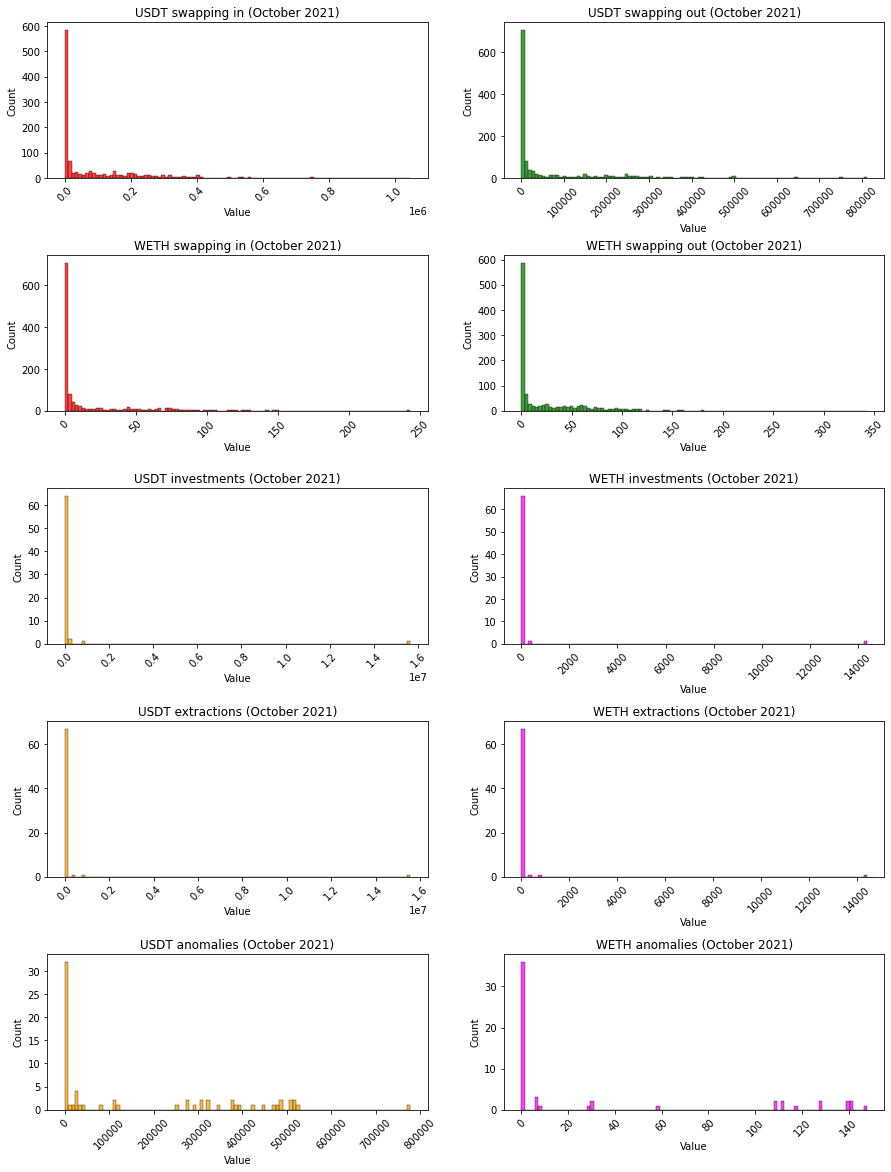

In [160]:
th.histplots_matrix(15, 20, 0.5, 0.2, 'October 2021', 100)

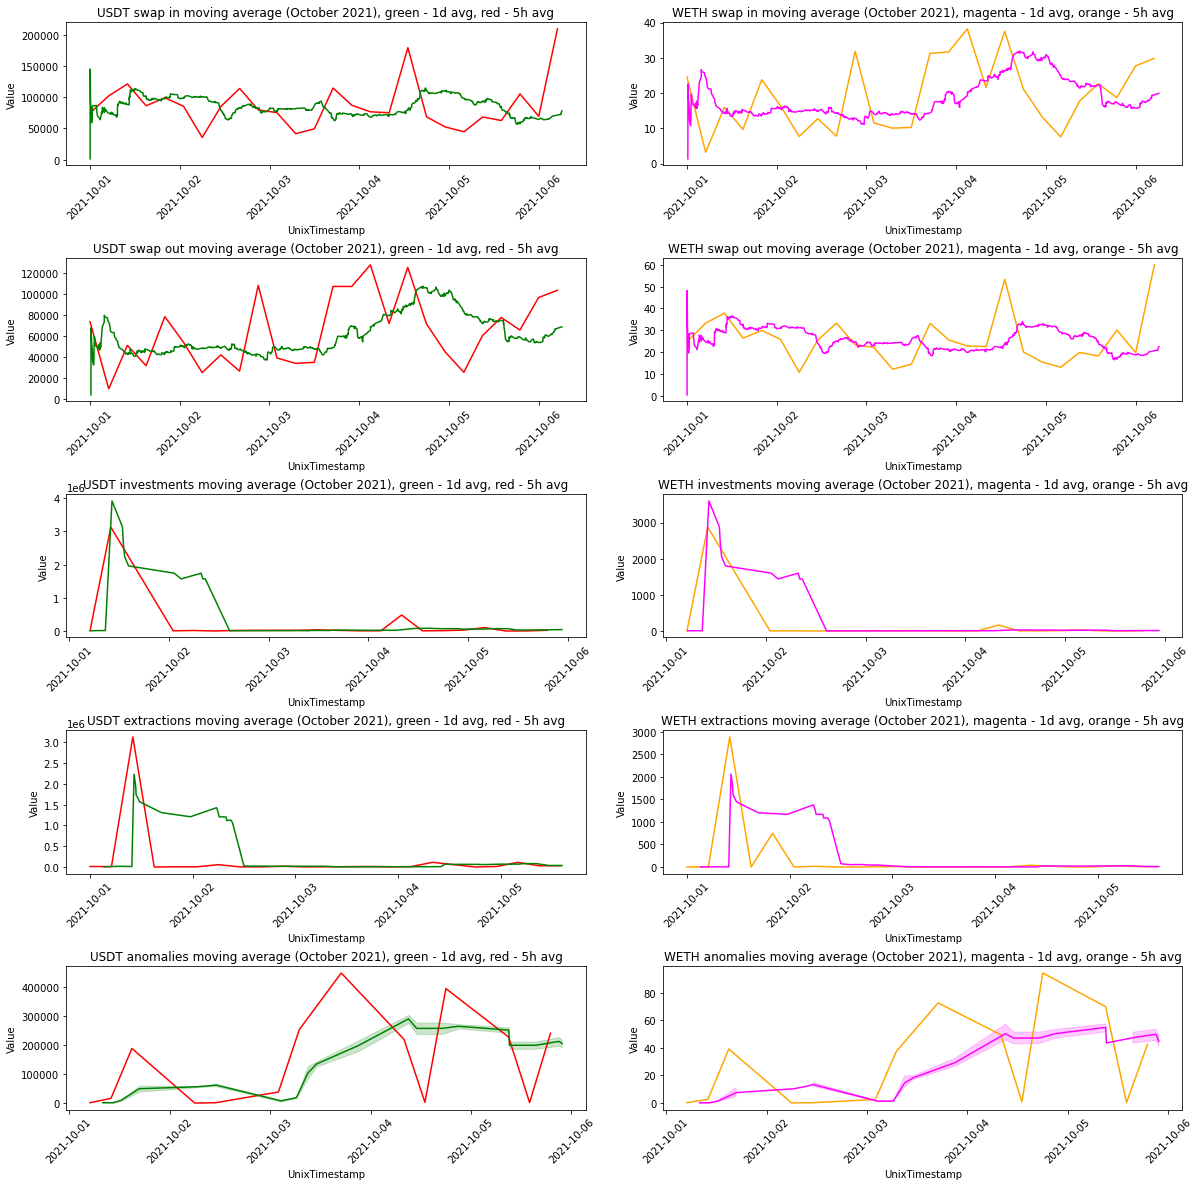

In [161]:
th.lineplots_moving_averages_matrix_by_token(20, 20, 0.65, 0.15, 'USDT', 'WETH', 'October 2021', '5h', '1d')

## FRAX/USDC

In [162]:
# read transaction history
frax_usdc_df = pd.read_csv(os.getcwd() + "\stress_test_sim\pools_history\high_FRAX-USDC_01-10_31-10.csv", index_col=False)

# make sure that Value will be interpreted as floating point number, remove possible 0 value elements
frax_usdc_df.Value = frax_usdc_df.Value.str.replace(",", "")
frax_usdc_df.Value = frax_usdc_df.Value.astype("float")
frax_usdc_df = frax_usdc_df[frax_usdc_df.Value > 0]

# make sure that datetime parameter is interpreted as date
frax_usdc_df['Datetime'] = pd.to_datetime(frax_usdc_df['UnixTimestamp'], unit='s')

# form transaction history separated by categories
th = TransactionHistory()
th.classify_history(frax_usdc_df)

['USDC' 'FRAX']


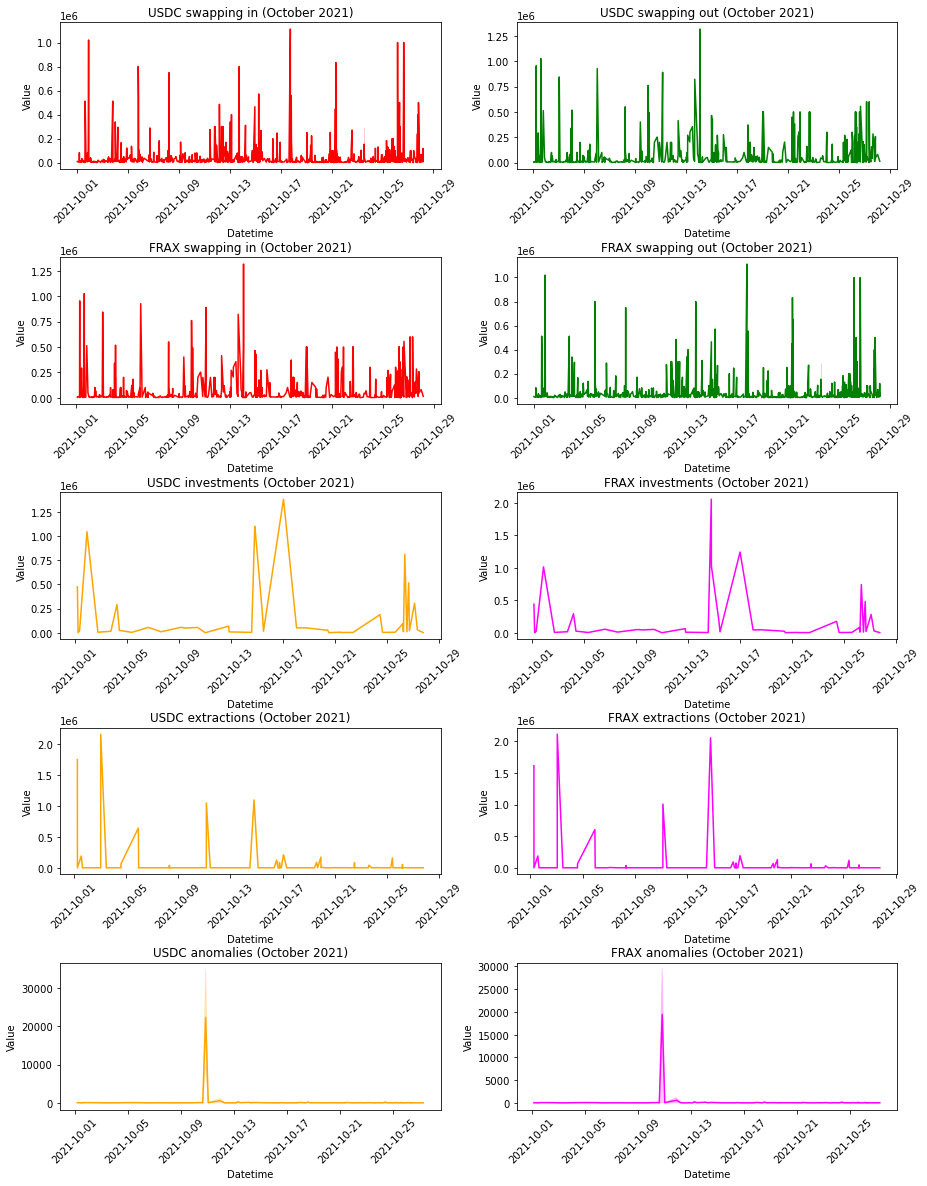

In [163]:
th.lineplots_matrix(15, 20, 0.6, 0.2, 'October 2021')

['USDC' 'FRAX']


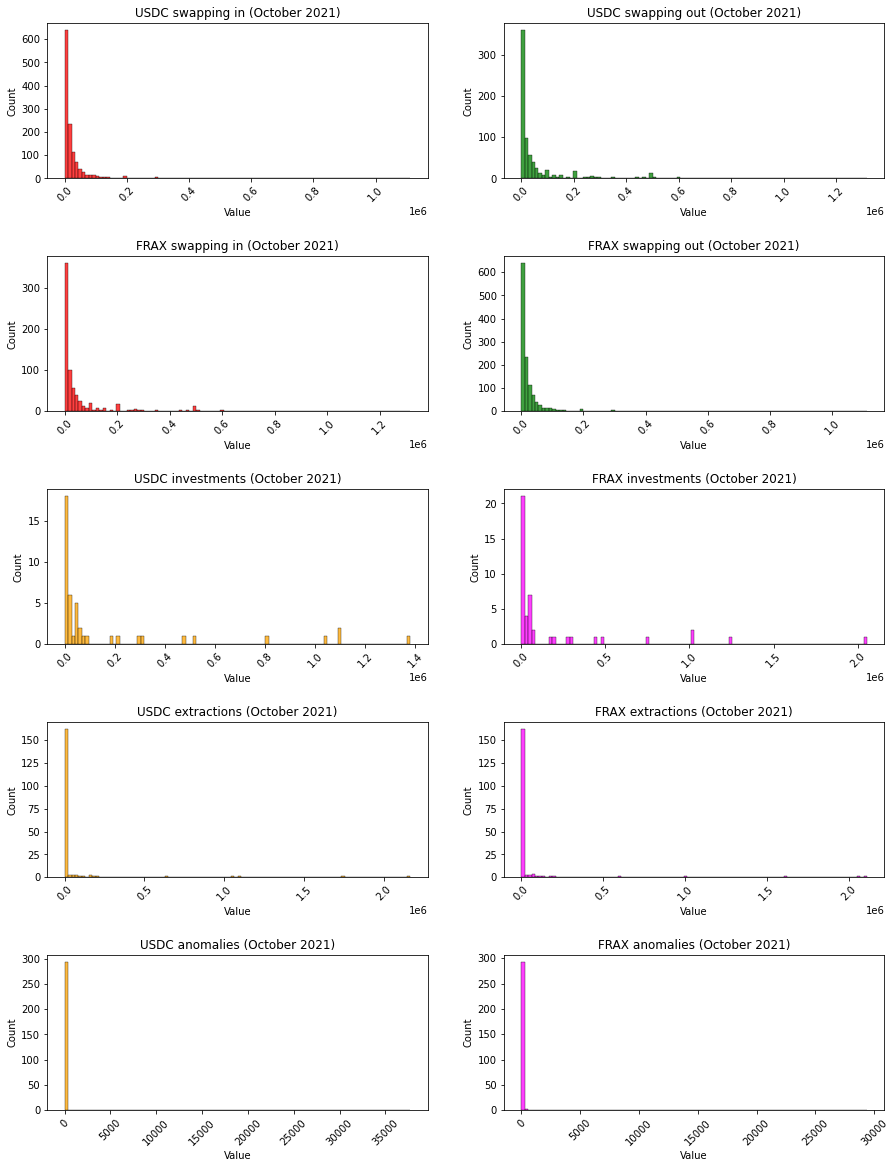

In [164]:
th.histplots_matrix(15, 20, 0.5, 0.2, 'October 2021', 100)

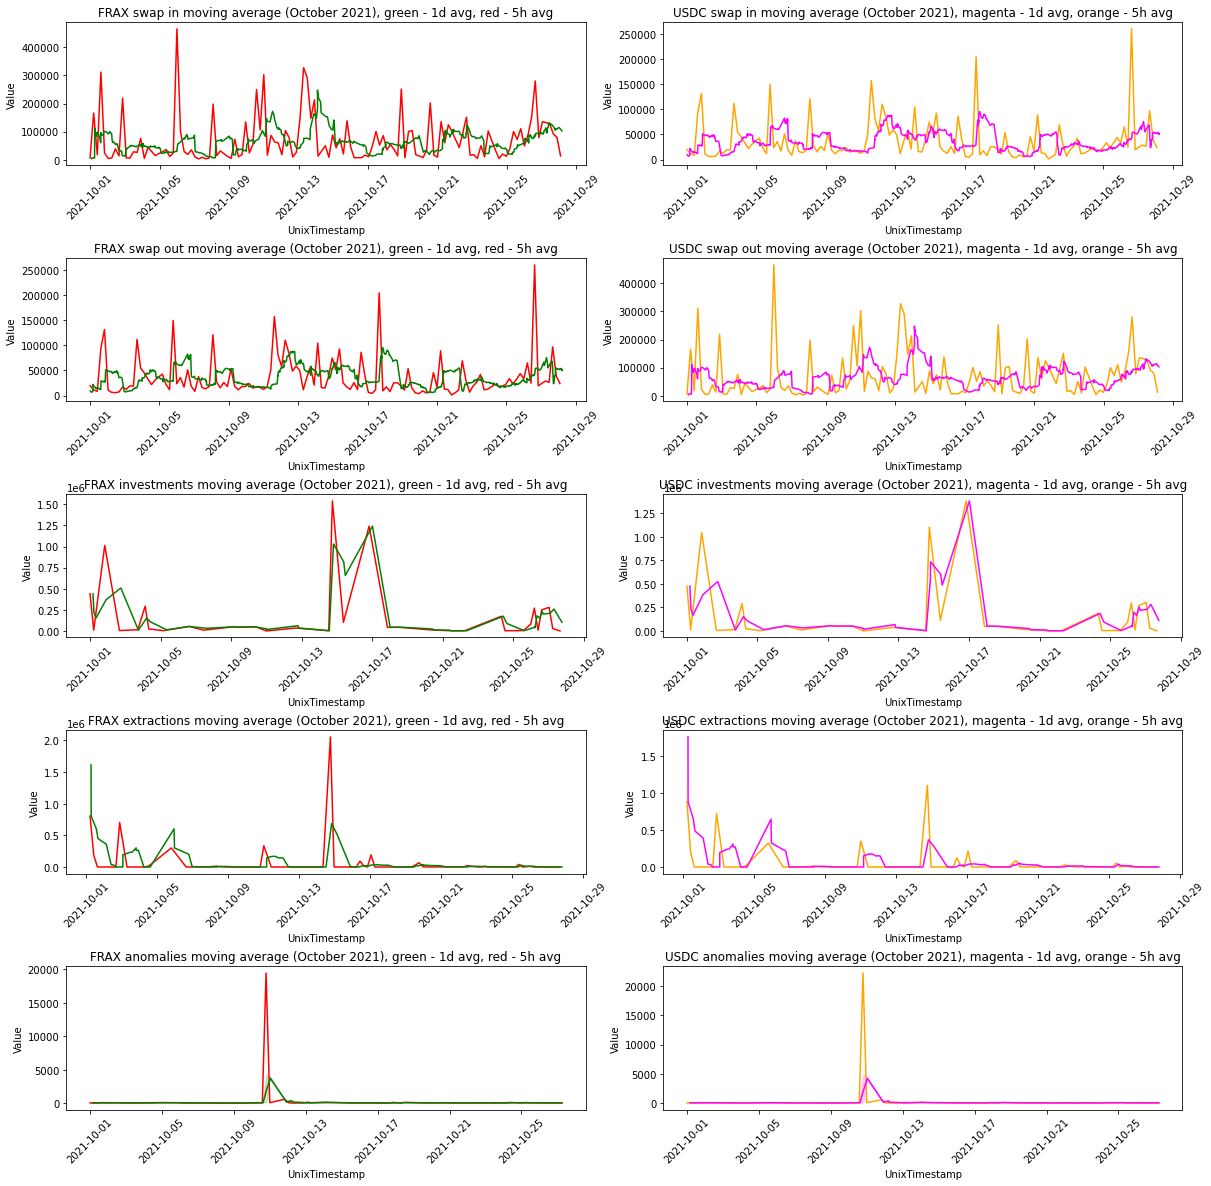

In [165]:
th.lineplots_moving_averages_matrix_by_token(20, 20, 0.65, 0.15, 'FRAX', 'USDC', 'October 2021', '5h', '1d')

# Low capitalization

## DAI/USDT

In [166]:
# read transaction history
dai_usdt_df = pd.read_csv(os.getcwd() + "\stress_test_sim\pools_history\low_DAI-USDT_01-10_31-10.csv", index_col=False)

# make sure that Value will be interpreted as floating point number, remove possible 0 value elements
dai_usdt_df.Value = dai_usdt_df.Value.str.replace(",", "")
dai_usdt_df.Value = dai_usdt_df.Value.astype("float")
dai_usdt_df = dai_usdt_df[dai_usdt_df.Value > 0]

# make sure that datetime parameter is interpreted as date
dai_usdt_df['Datetime'] = pd.to_datetime(dai_usdt_df['UnixTimestamp'], unit='s')

# form transaction history separated by categories
th = TransactionHistory()
th.classify_history(dai_usdt_df)

['DAI' 'USDT']


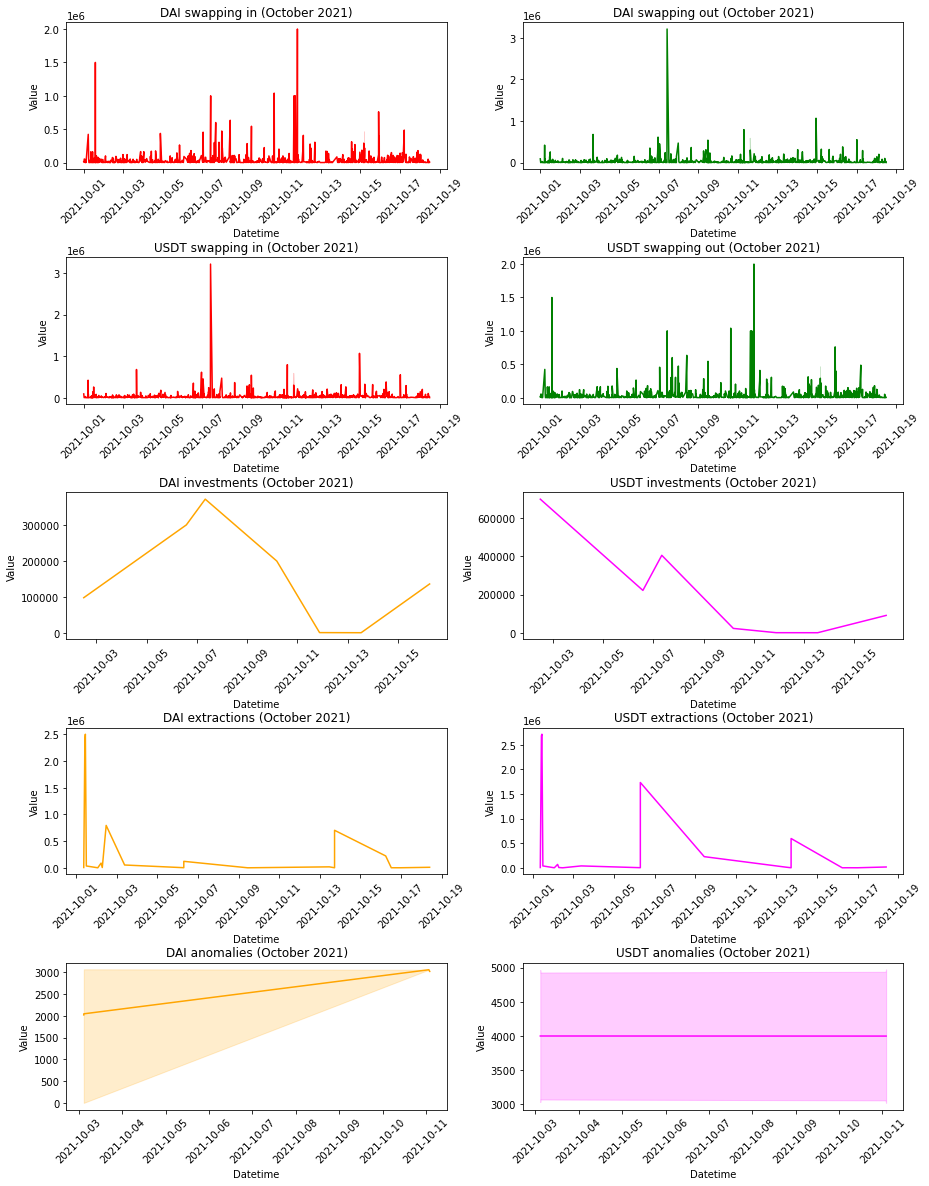

In [167]:
th.lineplots_matrix(15, 20, 0.6, 0.2, 'October 2021')

['DAI' 'USDT']


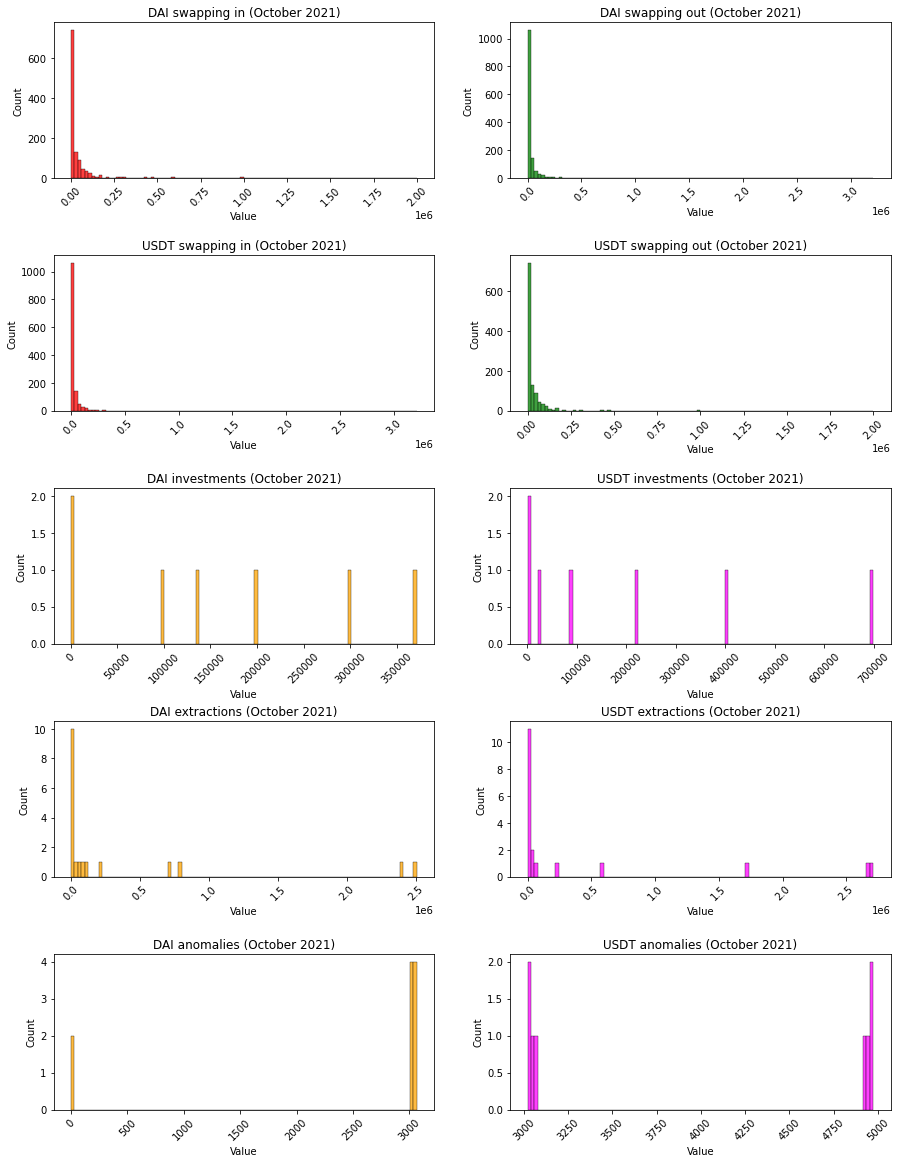

In [168]:
th.histplots_matrix(15, 20, 0.5, 0.2, 'October 2021', 100)

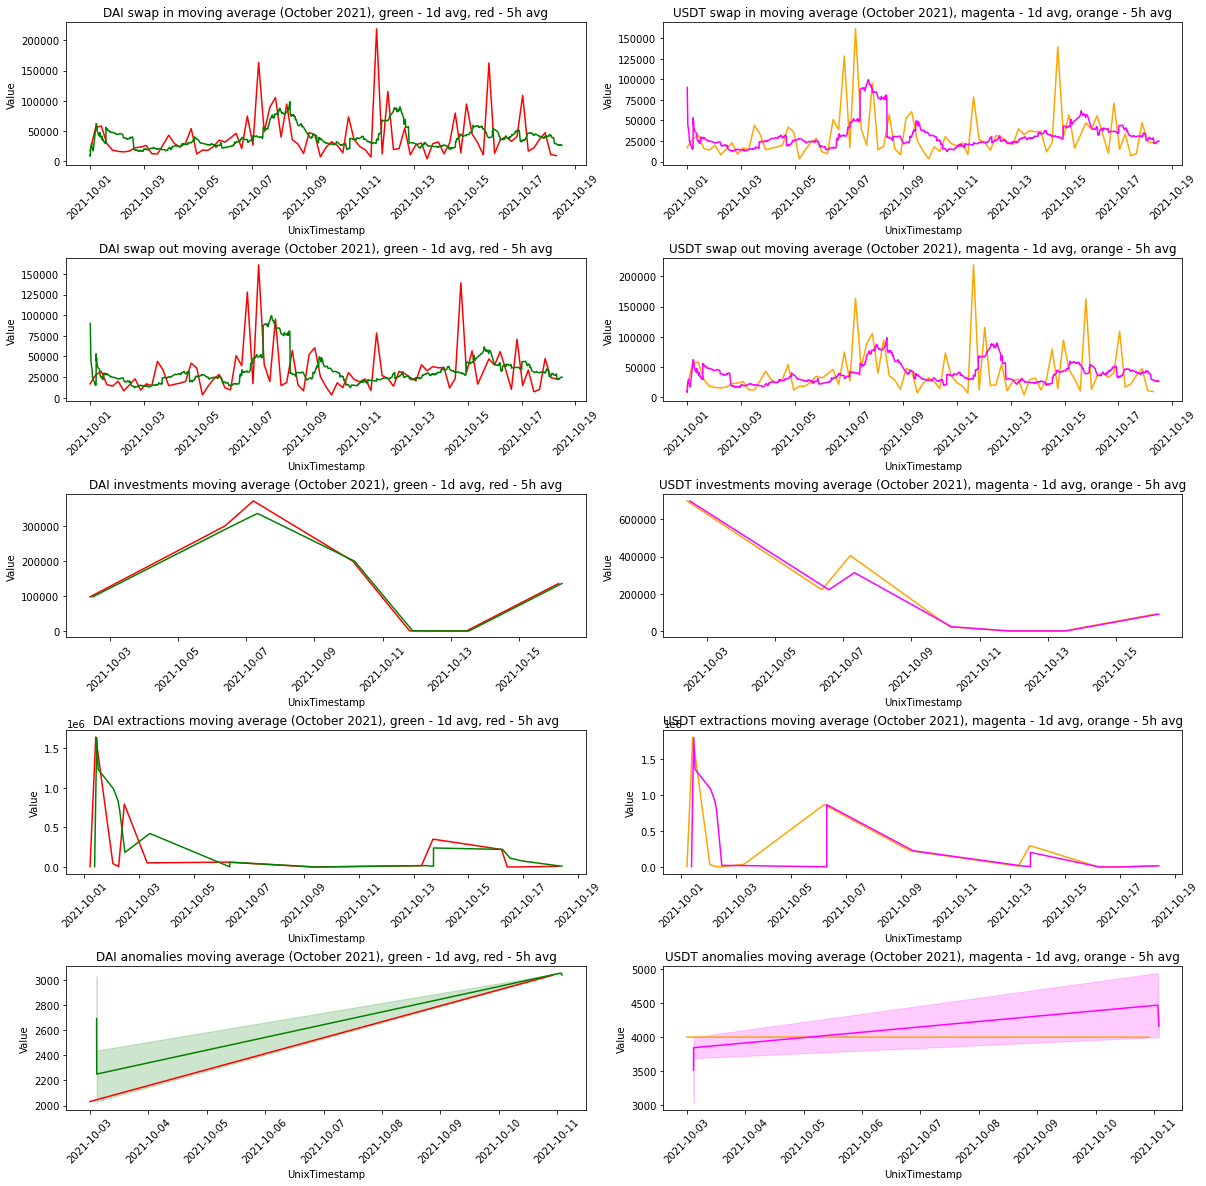

In [169]:
th.lineplots_moving_averages_matrix_by_token(20, 20, 0.65, 0.15, 'DAI', 'USDT', 'October 2021', '5h', '1d')

## FEI/USDC

In [170]:
# read transaction history
fei_usdc_df = pd.read_csv(os.getcwd() + "\stress_test_sim\pools_history\low_FEI-USDC_01-10_31-10.csv", index_col=False)

# make sure that Value will be interpreted as floating point number, remove possible 0 value elements
fei_usdc_df.Value = fei_usdc_df.Value.str.replace(",", "")
fei_usdc_df.Value = fei_usdc_df.Value.astype("float")
fei_usdc_df = fei_usdc_df[fei_usdc_df.Value > 0]

# make sure that datetime parameter is interpreted as date
fei_usdc_df['Datetime'] = pd.to_datetime(fei_usdc_df['UnixTimestamp'], unit='s')

# form transaction history separated by categories
th = TransactionHistory()
th.classify_history(fei_usdc_df)

['FEI' 'USDC']


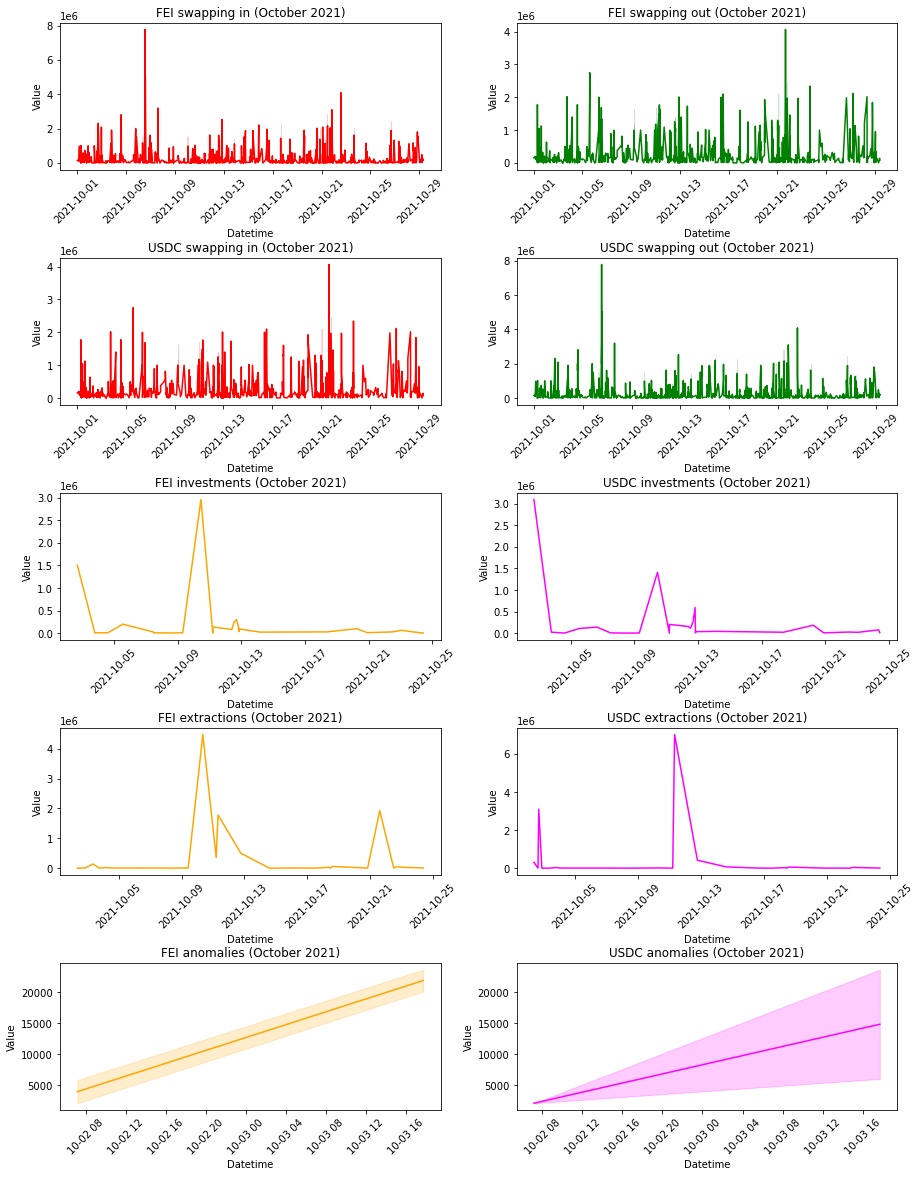

In [171]:
th.lineplots_matrix(15, 20, 0.6, 0.2, 'October 2021')

['FEI' 'USDC']


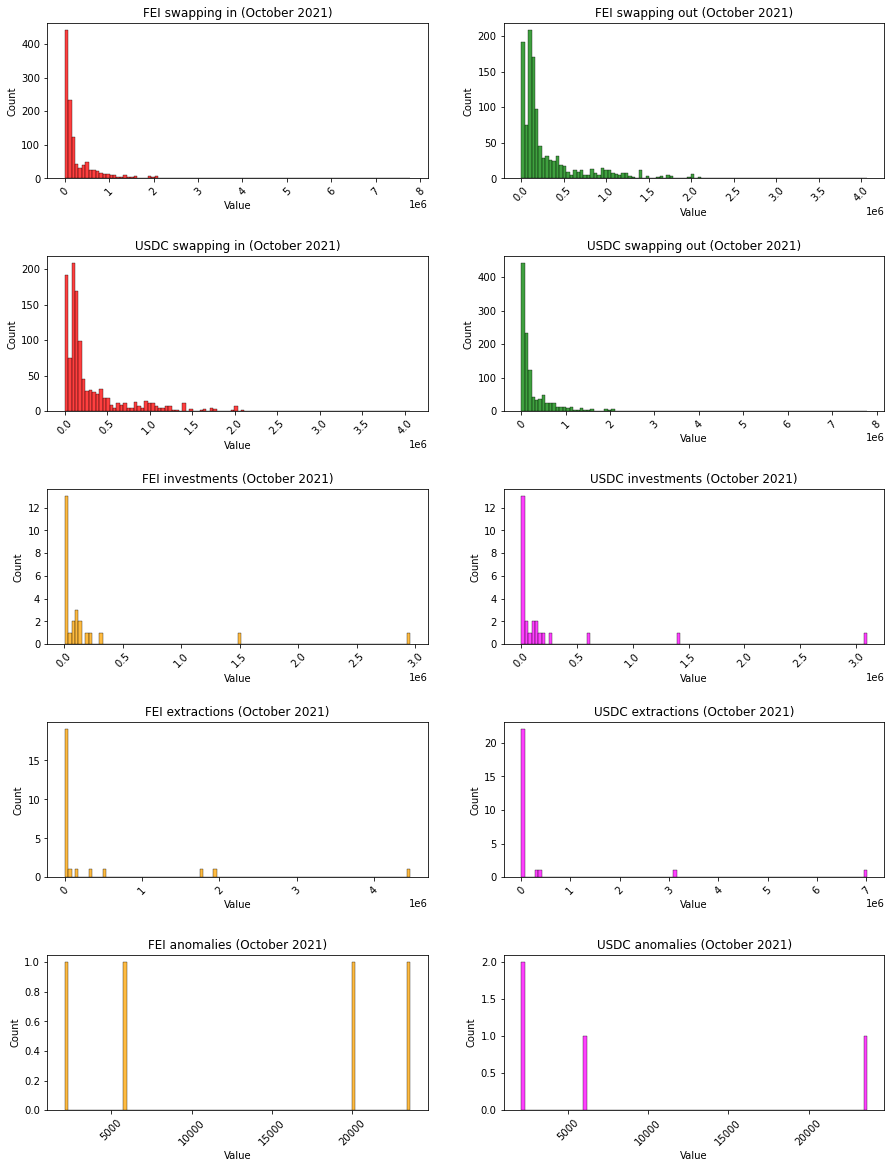

In [172]:
th.histplots_matrix(15, 20, 0.5, 0.2, 'October 2021', 100)

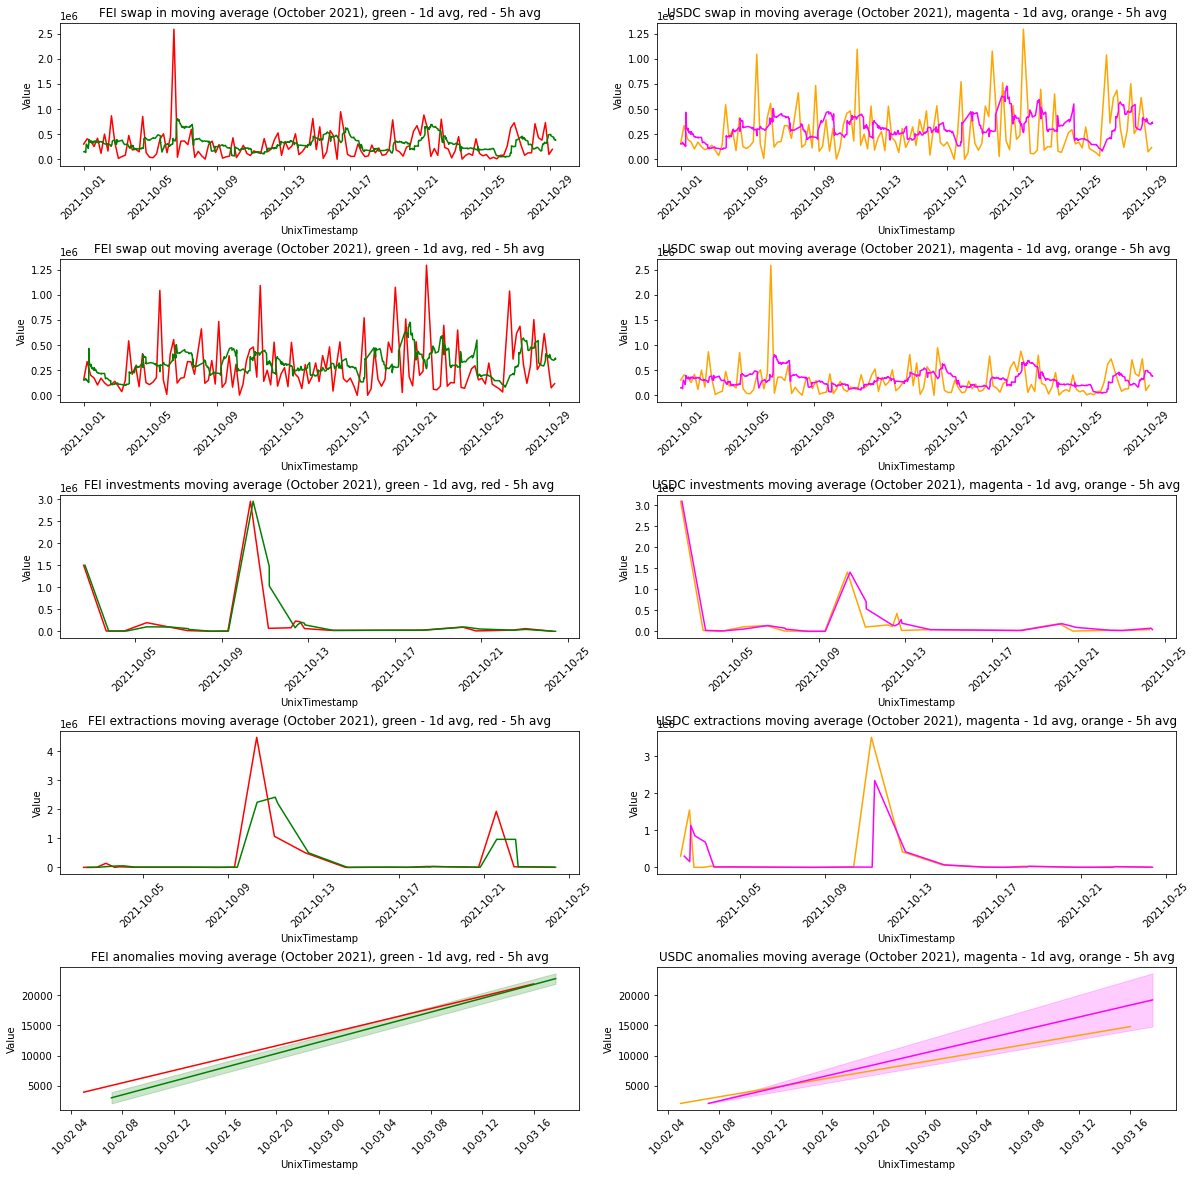

In [173]:
th.lineplots_moving_averages_matrix_by_token(20, 20, 0.65, 0.15, 'FEI', 'USDC', 'October 2021', '5h', '1d')

## PAX/USDC

In [174]:
# read transaction history
pax_usdc_df = pd.read_csv(os.getcwd() + "\stress_test_sim\pools_history\low_PAX-USDC_01-10_31-10.csv", index_col=False)

# make sure that Value will be interpreted as floating point number, remove possible 0 value elements
pax_usdc_df.Value = pax_usdc_df.Value.str.replace(",", "")
pax_usdc_df.Value = pax_usdc_df.Value.astype("float")
pax_usdc_df = pax_usdc_df[pax_usdc_df.Value > 0]

# make sure that datetime parameter is interpreted as date
pax_usdc_df['Datetime'] = pd.to_datetime(pax_usdc_df['UnixTimestamp'], unit='s')

# form transaction history separated by categories
th = TransactionHistory()
th.classify_history(pax_usdc_df)

['USDC' 'USDP']


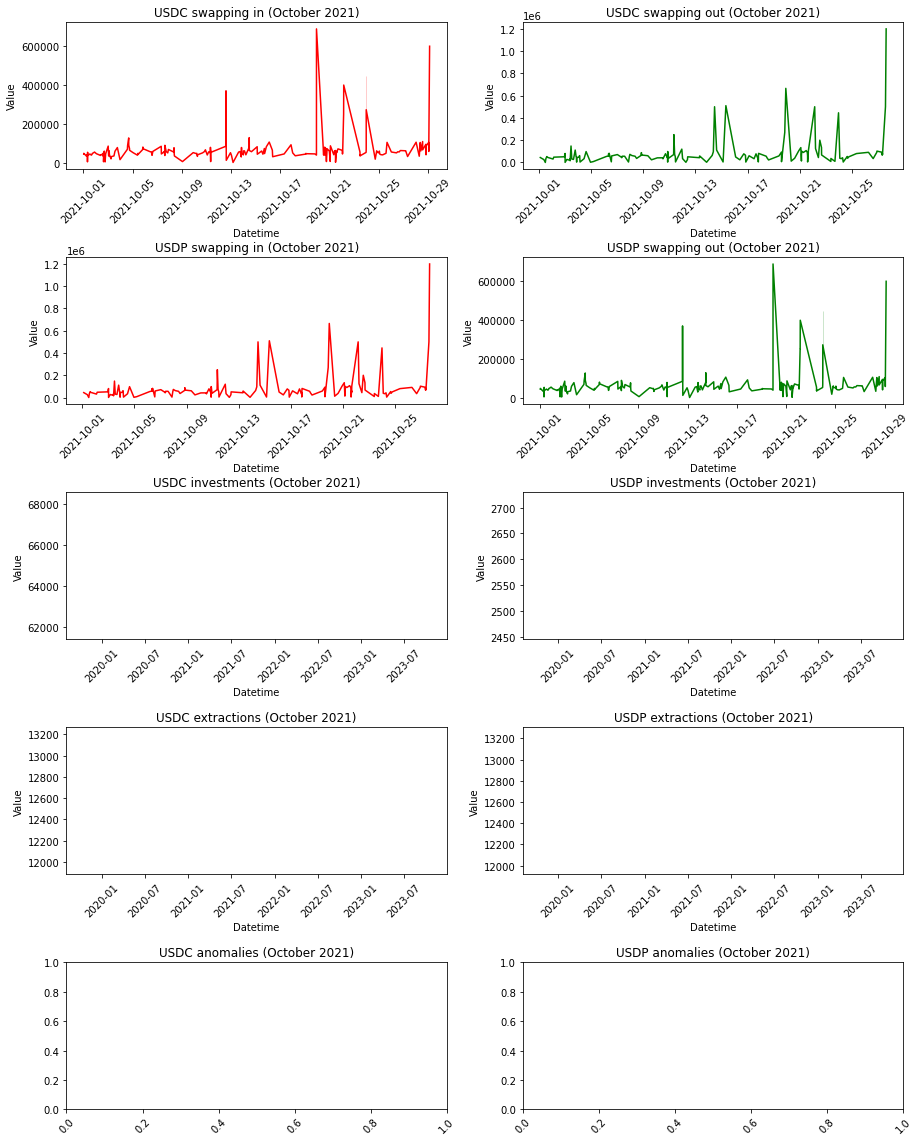

In [175]:
th.lineplots_matrix(15, 20, 0.6, 0.2, 'October 2021')

['USDC' 'USDP']


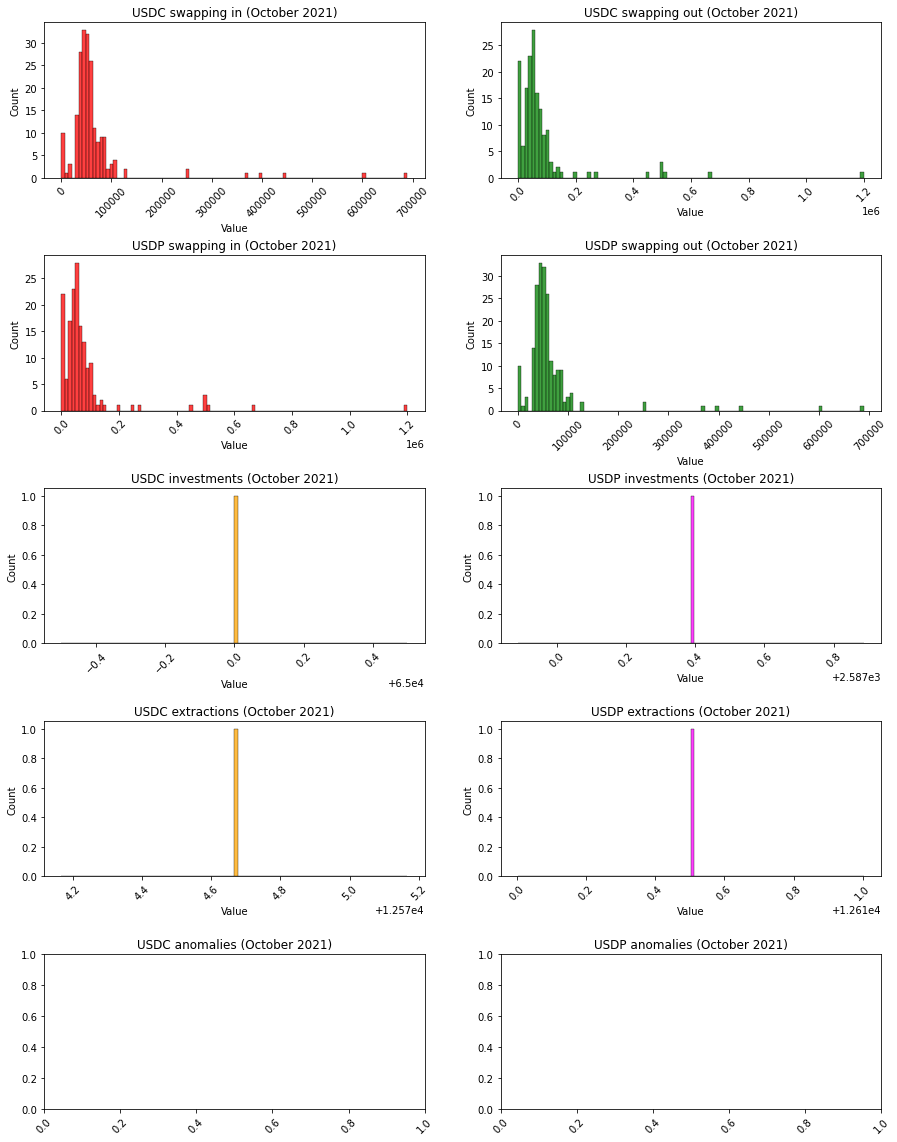

In [176]:
th.histplots_matrix(15, 20, 0.5, 0.2, 'October 2021', 100)

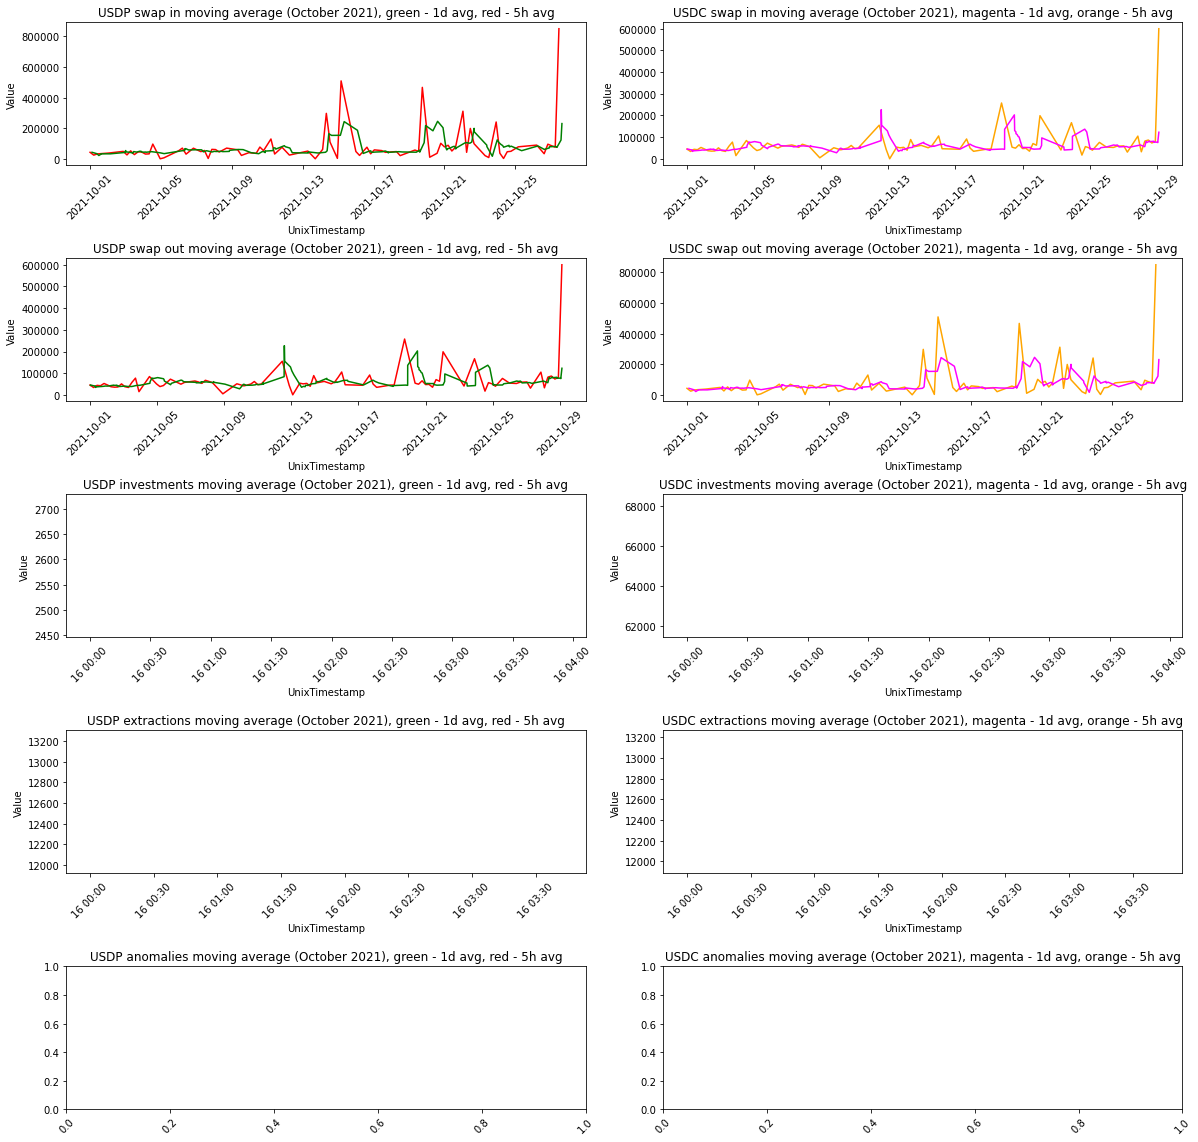

In [177]:
th.lineplots_moving_averages_matrix_by_token(20, 20, 0.65, 0.15, 'USDP', 'USDC', 'October 2021', '5h', '1d')

## WBTC/USDT

In [178]:
# read transaction history
wbtc_usdt_df = pd.read_csv(os.getcwd() + "\stress_test_sim\pools_history\low_WBTC-USDT_01-10_31-10.csv", index_col=False)

# make sure that Value will be interpreted as floating point number, remove possible 0 value elements
wbtc_usdt_df.Value = wbtc_usdt_df.Value.str.replace(",", "")
wbtc_usdt_df.Value = wbtc_usdt_df.Value.astype("float")
wbtc_usdt_df = wbtc_usdt_df[wbtc_usdt_df.Value > 0]

# make sure that datetime parameter is interpreted as date
wbtc_usdt_df['Datetime'] = pd.to_datetime(wbtc_usdt_df['UnixTimestamp'], unit='s')

# form transaction history separated by categories
th = TransactionHistory()
th.classify_history(wbtc_usdt_df)

['USDT' 'WBTC']


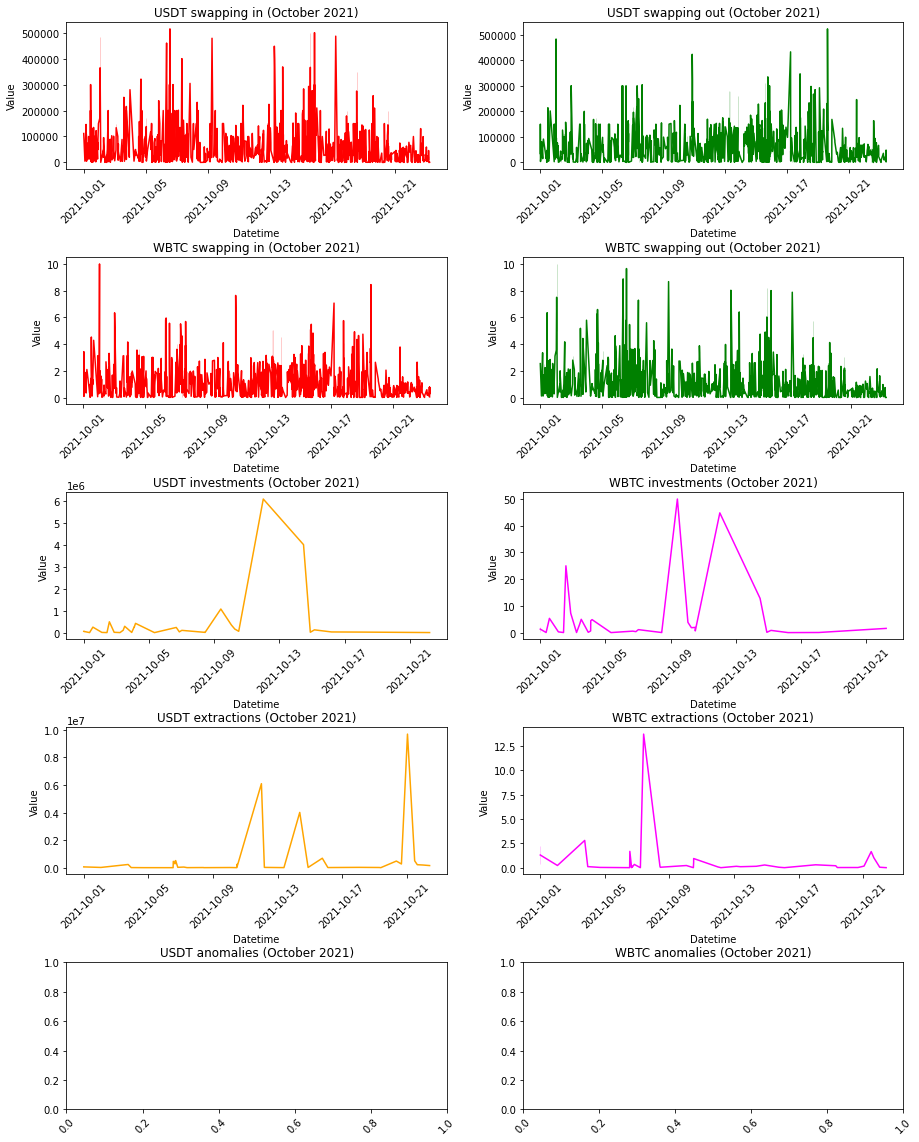

In [179]:
th.lineplots_matrix(15, 20, 0.6, 0.2, 'October 2021')

['USDT' 'WBTC']


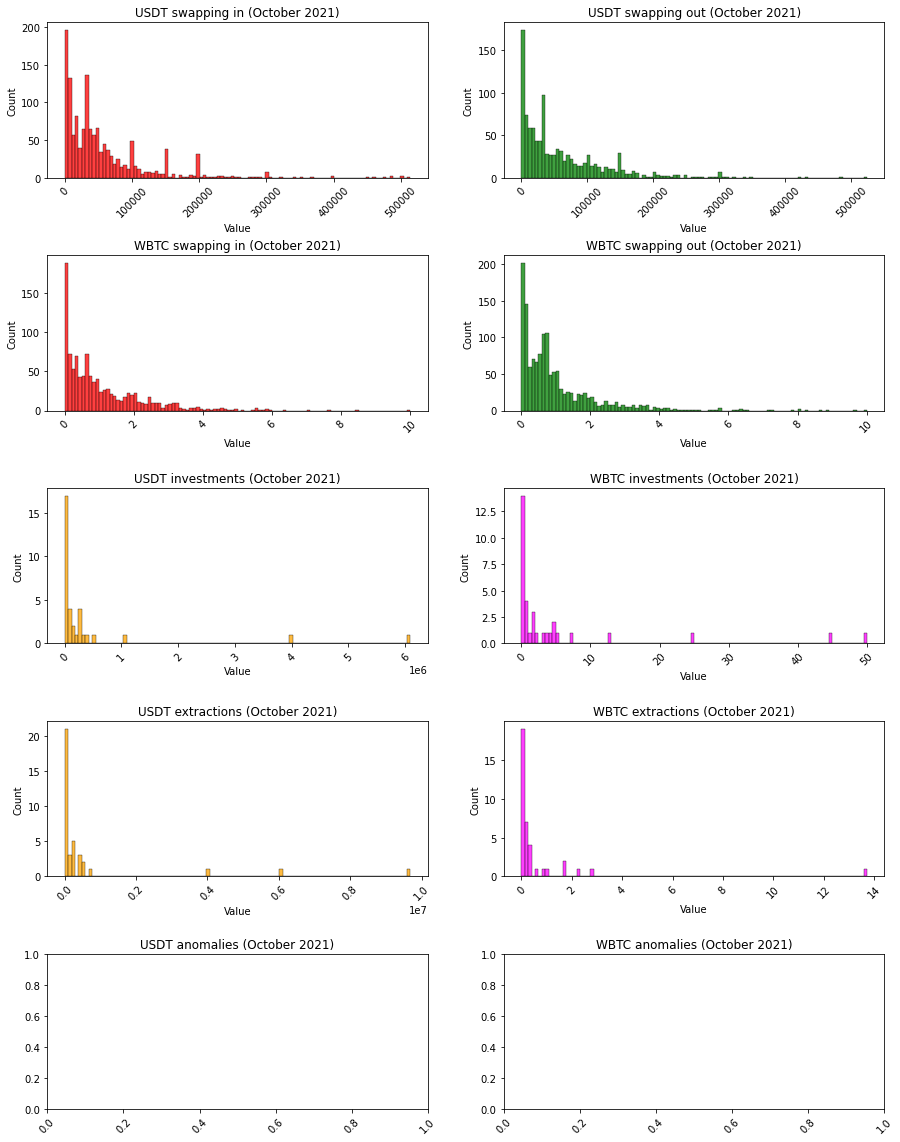

In [180]:
th.histplots_matrix(15, 20, 0.5, 0.2, 'October 2021', 100)

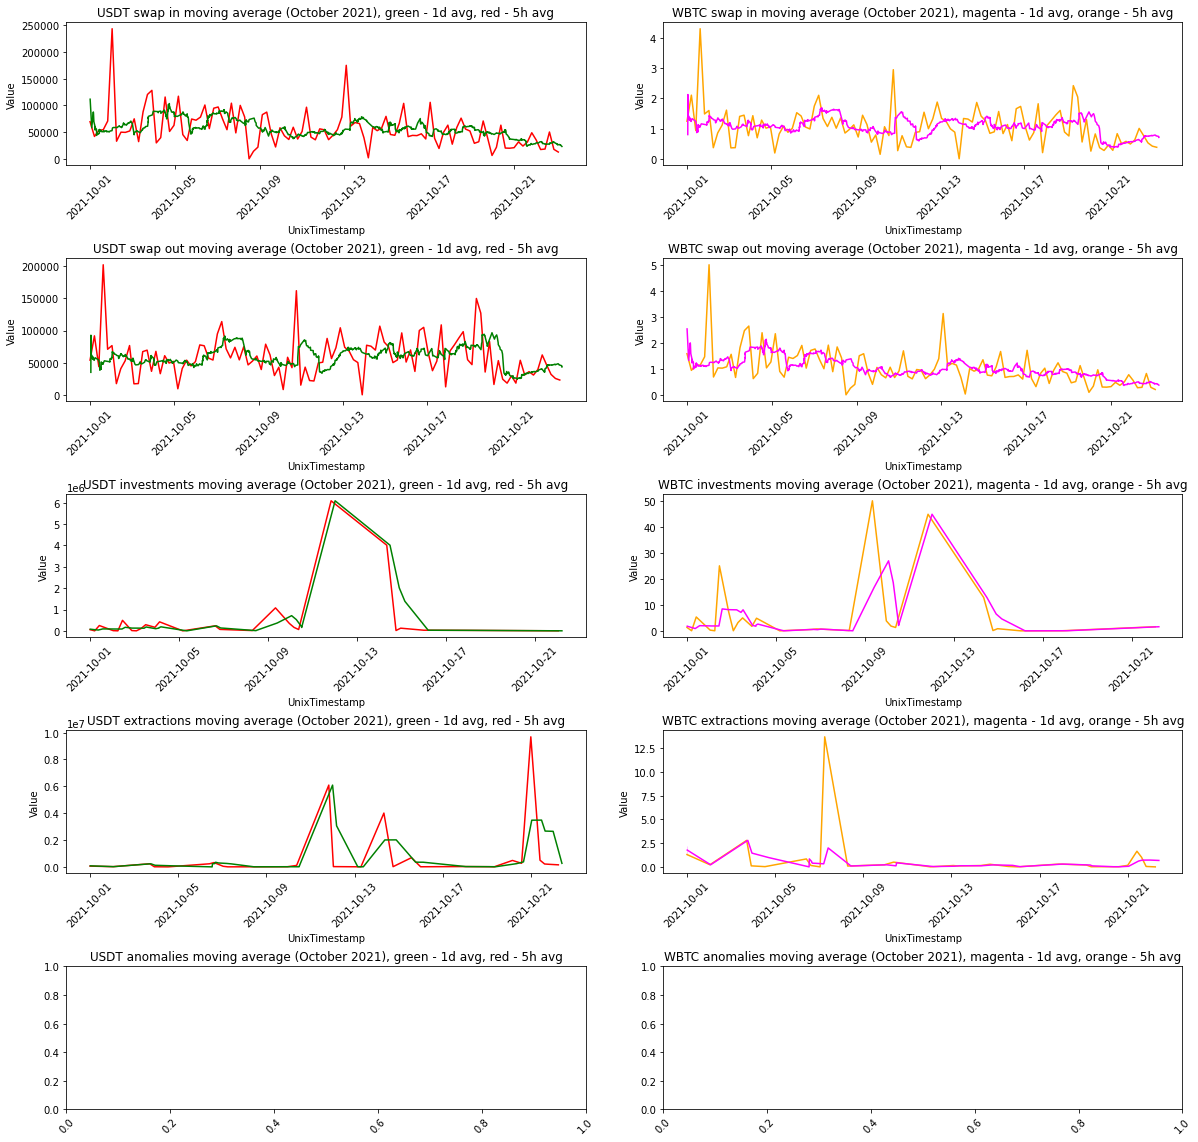

In [183]:
th.lineplots_moving_averages_matrix_by_token(20, 20, 0.65, 0.15, 'USDT', 'WBTC', 'October 2021', '5h', '1d')